# Overview

In this notebook, we conduct data cleaning of the merged table. 

**Author**: Oscar Javier Bastidas Jossa. 

**Email**: oscar.jossa@deusto.es.

In [97]:
import pandas as pd
import numpy as np
from utilities import Data_cleaning

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
import re
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [98]:
# Read data and assign the index

df = pd.read_hdf('../data/cleaned_dataset_v1.h5',  key='data')
df.fillna(0, inplace=True)
df.shape

(46192, 9142)

# Datacleaning and preprocessing


The data cleaning performed in the current session involves eliminating columns where all values are zero, as well as removing the initial number of series calculated from the merged file. Subsequently, recalculations were done using columns from the processed table in data_merged_table.ipynb. Additionally, total reps and total time values were calculated for all exercises, as well as for individual exercises.

## Nomenclature

- **variable**: Number of series. (e.g. 1 leg bridge (left) = 10)
- **variable**\_**reps**\_**n**: Number of reps per serie . (e.g. 1 leg bridge (left)_reps_1 = 5 -> 5 reps in the serie 1)
- **variable**\_**time**\_**n**: Time in seconds per serie (e.g. 1 leg bridge (left)_time_2 = 30s -> 30s in the serie 2)
- **sum_of_reps**: Sum of all the rep values executed during the session.
- **sum_of_time**: Sum of the total time values for all the exercises during the session.
- **sum_of_reps_per_exercise**: Sum of the rep values executed during the session per exercise.
- **sum_of_time_per_exercise**: Sum of the time values during the session per exercise.
- **total_count_of_series_reps**: The count of the series for reps.
- **total_count_of_series_time**: The count of the sereis for time.


In [99]:
# Removing all columns with zero values

columns_with_zero_values = df.columns[(df == 0).all()]
df = df.drop(columns=columns_with_zero_values)
df.head(5)

,session_executions_updated_at,user_programs_user_id,1 leg bridge (left),1 leg bridge (left)_reps_1,1 leg bridge (left)_reps_10,1 leg bridge (left)_reps_11,1 leg bridge (left)_reps_12,1 leg bridge (left)_reps_13,1 leg bridge (left)_reps_14,1 leg bridge (left)_reps_15,1 leg bridge (left)_reps_16,1 leg bridge (left)_reps_17,1 leg bridge (left)_reps_2,1 leg bridge (left)_reps_3,1 leg bridge (left)_reps_4,1 leg bridge (left)_reps_5,1 leg bridge (left)_reps_6,1 leg bridge (left)_reps_7,1 leg bridge (left)_reps_8,1 leg bridge (left)_reps_9,1 leg bridge (left)_time_1,1 leg bridge (left)_time_10,1 leg bridge (left)_time_11,1 leg bridge (left)_time_12,1 leg bridge (left)_time_13,1 leg bridge (left)_time_14,1 leg bridge (left)_time_15,1 leg bridge (left)_time_16,1 leg bridge (left)_time_17,1 leg bridge (left)_time_2,1 leg bridge (left)_time_3,1 leg bridge (left)_time_4,1 leg bridge (left)_time_5,1 leg bridge (left)_time_6,1 leg bridge (left)_time_7,1 leg bridge (left)_time_8,1 leg bridge (left)_time_9,1 leg bridge (right),1 leg bridge (right)_reps_1,1 leg bridge (right)_reps_10,1 leg bridge (right)_reps_11,1 leg bridge (right)_reps_12,1 leg bridge (right)_reps_13,1 leg bridge (right)_reps_14,1 leg bridge (right)_reps_15,1 leg bridge (right)_reps_16,1 leg bridge (right)_reps_17,1 leg bridge (right)_reps_2,1 leg bridge (right)_reps_3,1 leg bridge (right)_reps_4,1 leg bridge (right)_reps_5,1 leg bridge (right)_reps_6,1 leg bridge (right)_reps_7,1 leg bridge (right)_reps_8,1 leg bridge (right)_reps_9,1 leg bridge (right)_time_1,1 leg bridge (right)_time_10,1 leg bridge (right)_time_11,1 leg bridge (right)_time_12,1 leg bridge (right)_time_13,1 leg bridge (right)_time_14,1 leg bridge (right)_time_15,1 leg bridge (right)_time_16,1 leg bridge (right)_time_17,1 leg bridge (right)_time_2,1 leg bridge (right)_time_3,1 leg bridge (right)_time_4,1 leg bridge (right)_time_5,1 leg bridge (right)_time_6,1 leg bridge (right)_time_7,1 leg bridge (right)_time_8,1 leg bridge (right)_time_9,1 leg dead lift (left),1 leg dead lift (left)_reps_1,1 leg dead lift (left)_reps_10,1 leg dead lift (left)_reps_11,1 leg dead lift (left)_reps_12,1 leg dead lift (left)_reps_13,1 leg dead lift (left)_reps_14,1 leg dead lift (left)_reps_15,1 leg dead lift (left)_reps_2,1 leg dead lift (left)_reps_3,1 leg dead lift (left)_reps_4,1 leg dead lift (left)_reps_5,1 leg dead lift (left)_reps_6,1 leg dead lift (left)_reps_7,1 leg dead lift (left)_reps_8,1 leg dead lift (left)_reps_9,1 leg dead lift (left)_time_1,1 leg dead lift (left)_time_10,1 leg dead lift (left)_time_11,1 leg dead lift (left)_time_12,1 leg dead lift (left)_time_13,1 leg dead lift (left)_time_14,1 leg dead lift (left)_time_15,1 leg dead lift (left)_time_2,1 leg dead lift (left)_time_3,1 leg dead lift (left)_time_4,1 leg dead lift (left)_time_5,1 leg dead lift (left)_time_6,1 leg dead lift (left)_time_7,1 leg dead lift (left)_time_8,1 leg dead lift (left)_time_9,1 leg dead lift (right),1 leg dead lift (right)_reps_1,1 leg dead lift (right)_reps_10,1 leg dead lift (right)_reps_11,1 leg dead lift (right)_reps_12,1 leg dead lift (right)_reps_13,1 leg dead lift (right)_reps_14,1 leg dead lift (right)_reps_15,1 leg dead lift (right)_reps_2,1 leg dead lift (right)_reps_3,1 leg dead lift (right)_reps_4,1 leg dead lift (right)_reps_5,1 leg dead lift (right)_reps_6,1 leg dead lift (right)_reps_7,1 leg dead lift (right)_reps_8,1 leg dead lift (right)_reps_9,1 leg dead lift (right)_time_1,1 leg dead lift (right)_time_10,1 leg dead lift (right)_time_11,1 leg dead lift (right)_time_12,1 leg dead lift (right)_time_13,1 leg dead lift (right)_time_14,1 leg dead lift (right)_time_15,1 leg dead lift (right)_time_2,1 leg dead lift (right)_time_3,1 leg dead lift (right)_time_4,1 leg dead lift (right)_time_5,1 leg dead lift (right)_time_6,1 leg dead lift (right)_time_7,1 leg dead lift (right)_time_8,1 leg dead lift (right)_time_9,1 leg dead lift 1with KB (right),1 leg dead lift 1with KB (right)_reps_1,1 leg dead lift 1with KB (righ

In [100]:
# Removing the Initial columns that containt the total number of series 

columns_without_reps_and_time = df.columns[~((df.columns.str.contains("_reps_")) |
                                             (df.columns.str.contains("_time_")) |      
                                             (df.columns.str.contains("session_executions_updated_at")) |
                                             (df.columns.str.contains("user_programs_user_id")) |
                                             (df.columns.str.contains("date")) |                                             
                                             (df.columns.str.contains("session_executions_summary_total_kcal")) |
                                             (df.columns.str.contains("session_executions_summary_effort")) |
                                             (df.columns.str.contains("session_executions_summary_points")) |
                                             (df.columns.str.contains("session_executions_summary_value_of_session")) )]

df = df.drop(columns=columns_without_reps_and_time)
df.shape

(46192, 6909)

In [101]:
# Drop columns to only itereate over the exercises

df_exercises = df.drop(columns=['session_executions_updated_at', 
                                'user_programs_user_id', 
                                'session_executions_summary_effort',
                                'session_executions_summary_points',
                                'session_executions_summary_total_kcal',
                                'session_executions_summary_value_of_session',
                                'date'])

In [102]:
def add_count_and_sum_columns(df):
    """
    Add the followings columns to a DataFrame.
    sum_of_reps: Sum of all the rep values executed during the session.
    sum_of_time: Sum of the total time values for all the exercises during the session.
    sum_of_reps_per_exercise: Sum of the rep values executed during the session per exercise.
    sum_of_time_per_exercise: Sum of the time values during the session per exercise.
    total_count_of_series_reps: The count of the series for reps.
    total_count_of_series_time: The count of the sereis for time.

    Parameters:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    pandas.DataFrame: DataFrame with added columns.
    """
    count_reps_all = {}
    
    for index, row in df.iterrows():
        
        # Get the name of the columns which the values are different from zero
        series_name = row[row.astype(bool)].keys()
        
        # Initialize empty dicts to store the variables to add
        count_reps = {}
        sum_of_reps = {'sum_of_reps':0}
        sum_of_reps_per_exercise = {}
        count_times = {}
        sum_of_time = {'sum_of_time':0}
        sum_of_time_per_exercise = {}

        # Loop through each item in the series
        for item in series_name:

            if "_reps_" in item:
                
                # Split the item by "_reps_" to extract the group name
                group_name_reps = item.split("_reps_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_reps + "_reps") not in count_reps:
                    count_reps[group_name_reps + "_reps"] = 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = 0
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_reps[group_name_reps + "_reps"] += 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                sum_of_reps['sum_of_reps'] = sum_of_reps['sum_of_reps'] + row[item]

            elif ("_time_") in item:
                
                # Split the item by "_time_" to extract the group name
                group_name_time = item.split("_time_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_time + "_time") not in count_times:
                    count_times[group_name_time + "_time"] = 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = 0
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_times[group_name_time + "_time"] += 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                sum_of_time['sum_of_time'] = sum_of_time['sum_of_time'] + row[item]
            else:
                pass

        count_reps['total_count_of_series_reps'] = sum(count_reps.values())
        count_times['total_count_of_series_time'] = sum(count_times.values())

        count_reps_all[index] = count_reps | sum_of_reps | sum_of_reps_per_exercise | count_times | sum_of_time | sum_of_time_per_exercise
        
    # Convert the dictionary to a DataFrame
    df_to_append = pd.DataFrame.from_dict(count_reps_all, orient='index')
    df_series_recalculated = pd.concat([df, df_to_append], axis=1)

    # Replacing NaN with 0
    df_series_recalculated.fillna(0, inplace=True)
    
    return (df_series_recalculated)

In [103]:
df_series_recalculated = add_count_and_sum_columns(df)

Important: Uncomment the following lines to test the final df with an individual user from the session execution summary table from the merge file

individual_session_execution = df_series_recalculated.loc[746205, :]
individual_session_execution.loc[individual_session_execution.astype(bool)]['sum_of_reps']

In [26]:
# Uncomment when is useful to store the index of the final session_executions
# with open('../data/index_session_execution.npy', 'wb') as f:
#    np.save(f, np.array(df_series_recalculated.index))

In [9]:
# This example is to check the values for the user 108 and his session 3737
session_1 = df_series_recalculated.loc[(df_series_recalculated['user_programs_user_id'] == 108) & 
                                       (df_series_recalculated.index == 3737) ]
test_108_3737 = session_1.loc[:, (session_1 != 0).all()] # Only used for testing purposes
test_108_3737

,session_executions_updated_at,user_programs_user_id,2 legs half burpee_reps_1,2 legs half burpee_reps_2,2 legs half burpee_reps_3,2 legs half burpee_time_1,2 legs half burpee_time_2,2 legs half burpee_time_3,Bridge_reps_1,Bridge_reps_10,Bridge_reps_2,Bridge_reps_3,Bridge_reps_4,Bridge_reps_5,Bridge_reps_6,Bridge_reps_7,Bridge_reps_8,Bridge_reps_9,Bridge_time_1,Bridge_time_10,Bridge_time_2,Bridge_time_3,Bridge_time_4,Bridge_time_5,Bridge_time_6,Bridge_time_7,Bridge_time_8,Bridge_time_9,Free thruster_reps_1,Free thruster_reps_2,Free thruster_reps_3,Free thruster_time_1,Free thruster_time_2,Free thruster_time_3,Knee push-up_reps_1,Knee push-up_reps_2,Knee push-up_reps_3,Knee push-up_time_1,Knee push-up_time_2,Knee push-up_time_3,Mckenzie_reps_1,Mckenzie_reps_2,Mckenzie_reps_3,Mckenzie_time_1,Mckenzie_time_2,Mckenzie_time_3,Mountain runner_reps_1,Mountain runner_reps_2,Mountain runner_reps_3,Mountain runner_time_1,Mountain runner_time_2,Mountain runner_time_3,Plank pivot_reps_1,Plank pivot_reps_2,Plank pivot_reps_3,Plank pivot_time_1,Plank pivot_time_2,Plank pivot_time_3,Rest_time_1,Rest_time_10,Rest_time_11,Rest_time_12,Rest_time_13,Rest_time_14,Rest_time_15,Rest_time_16,Rest_time_17,Rest_time_18,Rest_time_19,Rest_time_2,Rest_time_20,Rest_time_21,Rest_time_22,Rest_time_23,Rest_time_24,Rest_time_25,Rest_time_26,Rest_time_27,Rest_time_28,Rest_time_29,Rest_time_3,Rest_time_30,Rest_time_31,Rest_time_32,Rest_time_4,Rest_time_5,Rest_time_6,Rest_time_7,Rest_time_8,Rest_time_9,Side plank (left)_reps_1,Side plank (left)_reps_2,Side plank (left)_reps_3,Side plank (left)_reps_4,Side plank (left)_reps_5,Side plank (left)_reps_6,Side plank (left)_reps_7,Side plank (left)_reps_8,Side plank (left)_time_1,Side plank (left)_time_2,Side plank (left)_time_3,Side plank (left)_time_4,Side plank (left)_time_5,Side plank (left)_time_6,Side plank (right)_reps_1,Side plank (right)_reps_2,Side plank (right)_reps_3,Side plank (right)_reps_4,Side plank (right)_reps_5,Side plank (right)_reps_6,Side plank (right)_reps_7,Side plank (right)_reps_8,Side plank (right)_time_1,Side plank (right)_time_2,Side plank (right)_time_3,Side plank (right)_time_4,Side plank (right)_time_5,Side plank (right)_time_7,session_executions_summary_effort,session_executions_summary_points,session_executions_summary_total_kcal,session_executions_summary_value_of_session,date,2 legs half burpee_reps,Bridge_reps,Free thruster_reps,Knee push-up_reps,Mckenzie_reps,Mountain runner_reps,Plank pivot_reps,Side plank (left)_reps,Side plank (right)_reps,total_count_of_series_reps,sum_of_reps,2 legs half burpee_sum_of_reps_per_exercise,Bridge_sum_of_reps_per_exercise,Free thruster_sum_of_reps_per_exercise,Knee push-up_sum_of_reps_per_exercise,Mckenzie_sum_of_reps_per_exercise,Mountain runner_sum_of_reps_per_exercise,Plank pivot_sum_of_reps_per_exercise,Side plank (left)_sum_of_reps_per_exercise,Side plank (right)_sum_of_reps_per_exercise,2 legs half burpee_time,Bridge_time,Free thruster_time,Knee push-up_time,Mckenzie_time,Mountain runner_time,Plank pivot_time,Rest_time,Side plank (left)_time,Side plank (right)_time,total_count_of_series_time,sum_of_time,2 legs half burpee_sum_of_time_per_exercise,Bridge_sum_of_time_per_exercise,Free thruster_sum_of_time_per_exercise,Knee push-up_sum_of_time_per_exercise,Mckenzie_sum_of_time_per_exercise,Mountain runner_sum_of_time_per_exercise,Plank pivot_sum_of_time_per_exercise,Rest_sum_of_time_per_exercise,Side plank (left)_sum_of_time_per_exercise,Side plank (right)_sum_of_time_per_exercise
3737,2021-06-11 18:00:35.640406,108,10.0,10.0,10.0,35.0,35.0,34.0,10.0,8.0,8.0,10.0,8.0,10.0,8.0,8.0,8.0,8.0,23.0,18.0,43.0,20.0,19.0,19.0,25.0,18.0,17.0,16.0,10.0,10.0,10.0,24.0,22.0,24.0,10.0,10.0,10.0,21.0,24.0,21.0,10.0,10.0,10.0,24.0,23.0,21.0,10.0,10.0,10.0,10.0,8.0,7.0,10.0,10.0,10.0,29.0,25.0,25.0,19.0,9.0,7.0,1.0,3.0,10.0,3.0,46.0,1.0,3.0,4.0,8.0,3.0,2.0,5.0,10.0,6.0,16.0,1.0,12.0,4.0,1.0,5.0,2.0,12.0,1.0,6.0,5.0,4.0,88.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.

In [10]:
def regex_word_to_included(df, words_to_include):
    values_no_removed = []
    for word_to_include in words_to_include:
        pattern = re.compile(word_to_include)
        values_no_removed.append(df[df.keys().str.contains(pattern)])
    return values_no_removed

In [11]:
def barh_plot_of_columns(df,  plot_conf, words_to_include =[], ascending = True):

    values_no_removed = regex_word_to_included(df, words_to_include)

    max_series = pd.concat(values_no_removed)
    max_series = max_series.sort_values(ascending=False)
    
    max_regex = copy.copy(max_series)

    print("len_max_series: ", len(max_series))
    # Getting the first indicated values
    max_series = max_series[plot_conf['range_values_to_plot'][0]:plot_conf['range_values_to_plot'][1]]
    print(max_series[0:5])
    
    # Sorting and plotting
    ax = max_series.sort_values(ascending=ascending).plot(kind='barh', figsize=(10, 8))

    # Set title and labels
    ax.set_title(plot_conf['title'])
    ax.set_xlabel(plot_conf['xlabel'])
    ax.set_ylabel(plot_conf['ylabel'])

    # Show the plot
    plt.show()
    return max_regex

# Initial statistics descriptive 

In [12]:
df_describe = df_series_recalculated.describe()

In [13]:
# Columns to drop from the df
columns_to_remove = ['user_programs_user_id', 
                     #'total_count_of_series_time', 
                     #'total_count_of_series_reps', 
                     'sum_of_reps', 
                     'sum_of_time',
                     'session_executions_summary_effort',
                     'session_executions_summary_points',
                     'session_executions_summary_total_kcal',
                     'session_executions_summary_value_of_session']

## MAX VALUES

In [14]:
def get_max_values(df):
    
    # Drop the columns that we do not want to be included in the graph
    df = df.drop(columns=columns_to_remove)

    # Get the max values
    max_values = df.loc['max', :].sort_values(ascending=False)

    return max_values

max_values = get_max_values(df_describe)

### Max series per exercise (time and reps)

In [15]:
max_values

Jumping squat with weight_sum_of_reps_per_exercise    2.111101e+09
Jumping squat with weight_reps_1                      2.111101e+09
Windshield wiper_sum_of_reps_per_exercise             2.075805e+08
Windshield wiper_reps_4                               2.074569e+08
Weighted backward lunge_sum_of_reps_per_exercise      6.722224e+07
                                                          ...     
Lateral squat_time                                    1.000000e+00
Plank hand to opposite foot_time                      1.000000e+00
Quadruped Superman_time                               1.000000e+00
Spiderman_time                                        1.000000e+00
Tricep extension_time_7                               1.000000e+00
Name: max, Length: 8668, dtype: float64

len_max_series:  884
Pull-up_reps         102.0
Rest_time             97.0
Rest_reps             94.0
Pull-up_time          91.0
Knee push-up_time     53.0
Name: max, dtype: float64


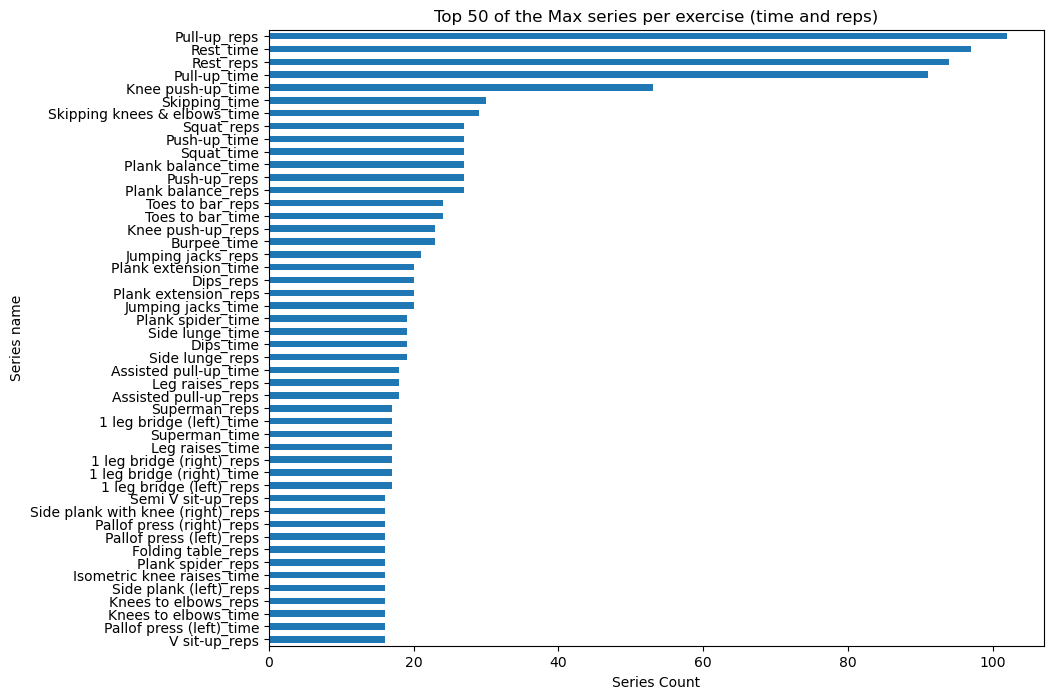

In [16]:
words_to_include = ['_time$', '_reps$']

range_reps = (2,50) #omitir total_count_of_series_reps y total_count_of_series_time
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the Max series per exercise (time and reps)',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

max_new = barh_plot_of_columns(max_values, plot_conf, words_to_include)

The previous graph indicates the top 10 of the max number of series executed during a session execution per exercise. For example the **Plan balance_reps** indicates that the max number of series executed was more than 20.

### Max values of repetitions per exercise

len_max_series:  3352
Windshield wiper_reps_4           207456921.0
Weighted backward lunge_reps_2     66666666.0
Forward thrust_reps_1              54444259.0
Squat_reps_5                        9999999.0
Push-up_reps_8                      9999999.0
Name: max, dtype: float64


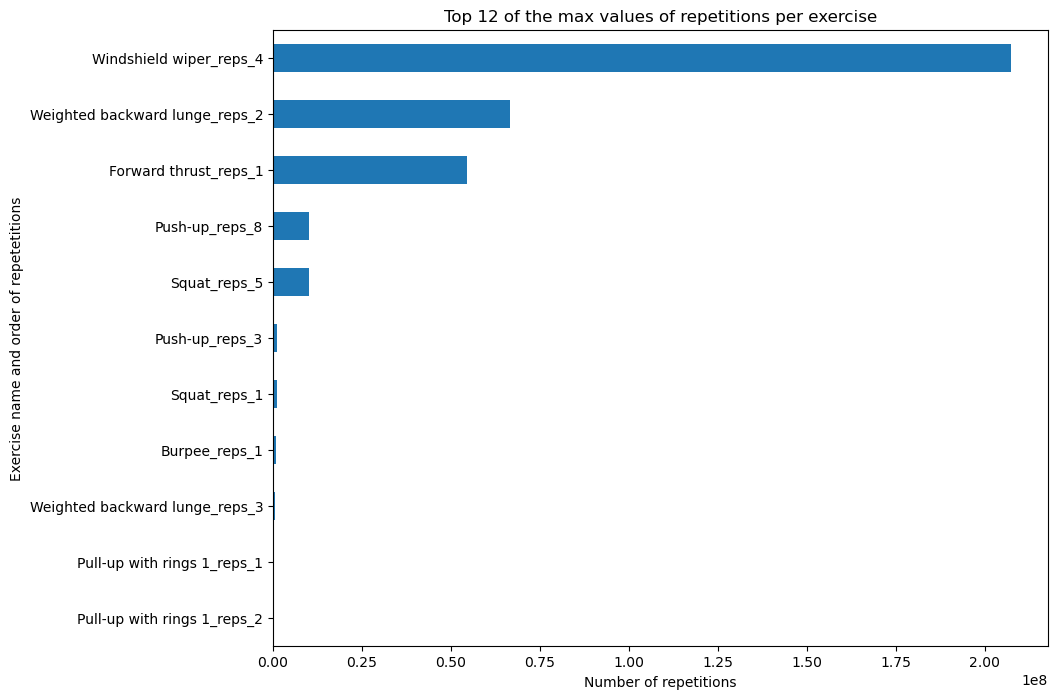

Jumping squat with weight_reps_1    2.111101e+09
Windshield wiper_reps_4             2.074569e+08
Weighted backward lunge_reps_2      6.666667e+07
Forward thrust_reps_1               5.444426e+07
Squat_reps_5                        9.999999e+06
                                        ...     
Rest_reps_24                        1.000000e+00
Rest_reps_25                        1.000000e+00
Rest_reps_26                        1.000000e+00
Rest_reps_27                        1.000000e+00
Knee push-up_reps_22                1.000000e+00
Name: max, Length: 3352, dtype: float64

In [17]:
words_to_include = ['_reps_\d']

range_reps = (1,12)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the max values of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetetitions'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)


### Max values of time per exercise

len_max_series:  3550
Diver_time_1                  4893.0
Pivot lunges (left)_time_2    3861.0
Rest_time_1                   3752.0
Plank balance_time_1          3719.0
Rest_time_2                   3667.0
Name: max, dtype: float64


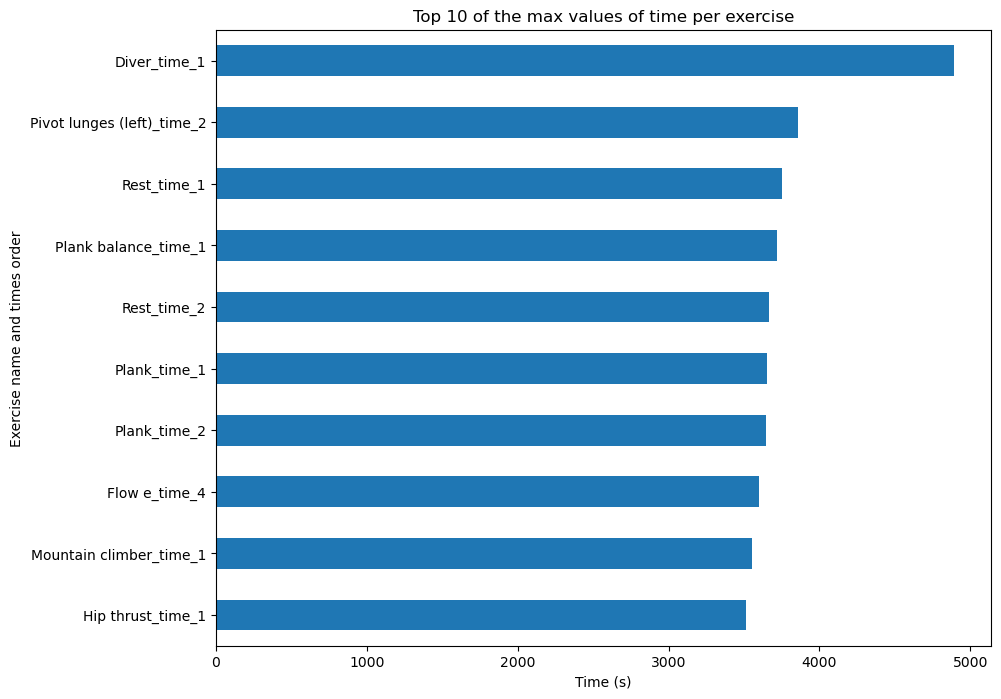

Diver_time_1                  4893.0
Pivot lunges (left)_time_2    3861.0
Rest_time_1                   3752.0
Plank balance_time_1          3719.0
Rest_time_2                   3667.0
                               ...  
Pull-up_time_83                  1.0
Pull-up_time_82                  1.0
Pull-up_time_100                 1.0
Pull-up_time_101                 1.0
Tricep extension_time_7          1.0
Name: max, Length: 3550, dtype: float64

In [18]:
words_to_include= ['_time_\d']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the max values of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)

### Max number of the sum of repetitions per exercise

len_max_series:  430
Jumping squat with weight_sum_of_reps_per_exercise    2.111101e+09
Windshield wiper_sum_of_reps_per_exercise             2.075805e+08
Weighted backward lunge_sum_of_reps_per_exercise      6.722224e+07
Forward thrust_sum_of_reps_per_exercise               5.444426e+07
Push-up_sum_of_reps_per_exercise                      1.113099e+07
Name: max, dtype: float64


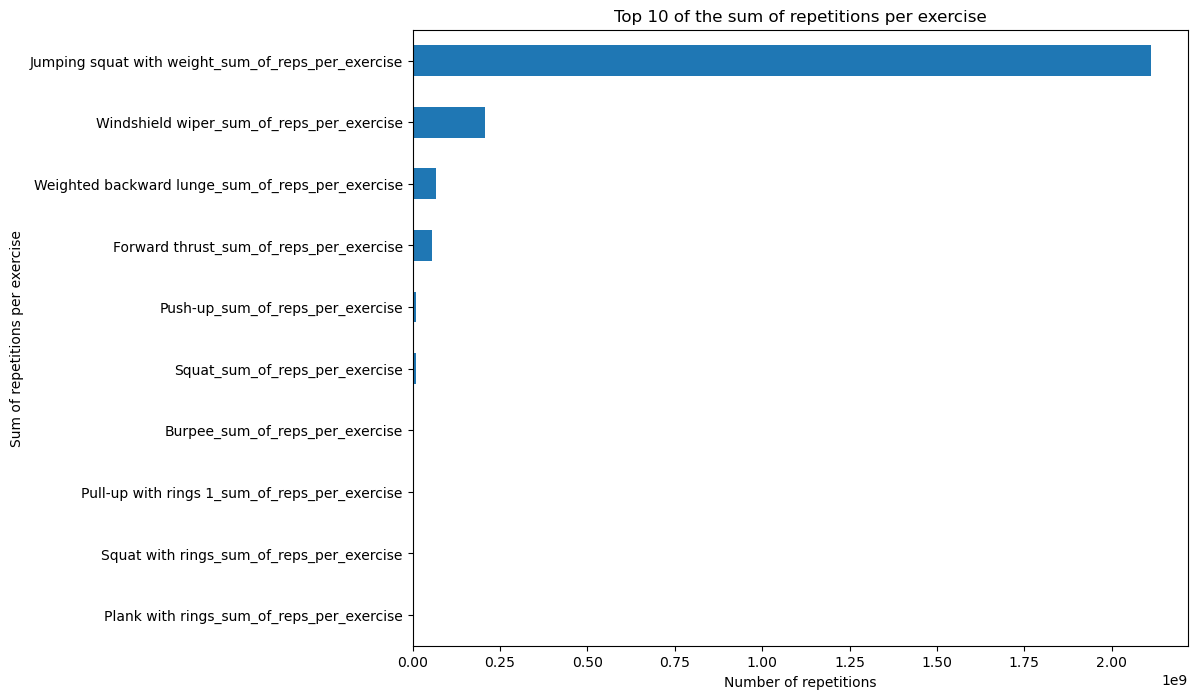

Jumping squat with weight_sum_of_reps_per_exercise                  2.111101e+09
Windshield wiper_sum_of_reps_per_exercise                           2.075805e+08
Weighted backward lunge_sum_of_reps_per_exercise                    6.722224e+07
Forward thrust_sum_of_reps_per_exercise                             5.444426e+07
Push-up_sum_of_reps_per_exercise                                    1.113099e+07
Squat_sum_of_reps_per_exercise                                      1.102100e+07
Burpee_sum_of_reps_per_exercise                                     8.889160e+05
Pull-up with rings 1_sum_of_reps_per_exercise                       2.700000e+05
Squat with rings_sum_of_reps_per_exercise                           4.800000e+04
Plank with rings_sum_of_reps_per_exercise                           3.337000e+04
Sit-up_sum_of_reps_per_exercise                                     1.599300e+04
Plank balance_sum_of_reps_per_exercise                              9.732000e+03
Lunges (left)_sum_of_reps_pe

In [19]:
words_to_include = ['_sum_of_reps_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the sum of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)

### Max number of the sum of time per exercise

len_max_series:  452
Rest_sum_of_time_per_exercise                             42736.0
Eccentric subescapular (left)_sum_of_time_per_exercise    10133.0
Leg raises_sum_of_time_per_exercise                        9284.0
Hip thrust_sum_of_time_per_exercise                        8728.0
Goblet squat_sum_of_time_per_exercise                      7879.0
Name: max, dtype: float64


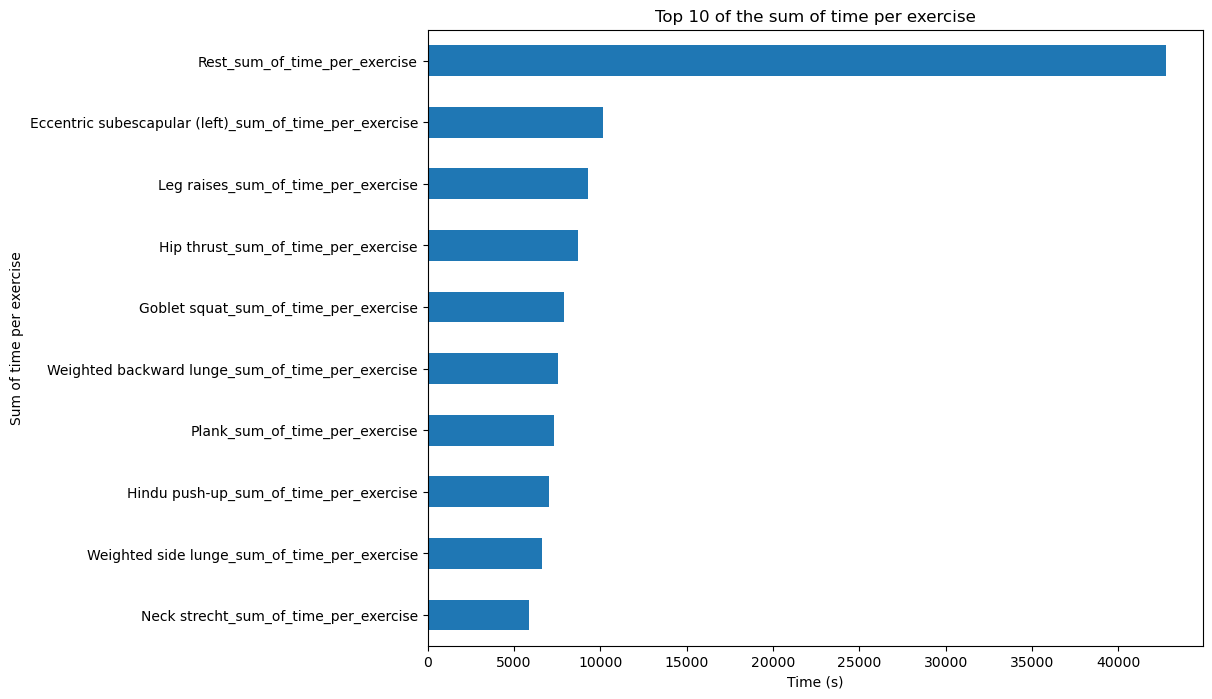

Rest_sum_of_time_per_exercise                                       42736.0
Eccentric subescapular (left)_sum_of_time_per_exercise              10133.0
Leg raises_sum_of_time_per_exercise                                  9284.0
Hip thrust_sum_of_time_per_exercise                                  8728.0
Goblet squat_sum_of_time_per_exercise                                7879.0
Weighted backward lunge_sum_of_time_per_exercise                     7522.0
Plank_sum_of_time_per_exercise                                       7303.0
Hindu push-up_sum_of_time_per_exercise                               7003.0
Weighted side lunge_sum_of_time_per_exercise                         6649.0
Neck strecht_sum_of_time_per_exercise                                5853.0
Thoracic extensions_sum_of_time_per_exercise                         5776.0
Pull-up_sum_of_time_per_exercise                                     5560.0
Mountain climber with rotation (right)_sum_of_time_per_exercise      5558.0
Diver_sum_of

In [20]:
words_to_include = ['_sum_of_time_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the sum of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)

## Median values

In [21]:
df_describe_zeros_excluded = df_series_recalculated.mask(df_series_recalculated==0).describe()

In [22]:
df_describe_zeros_excluded

,user_programs_user_id,1 leg bridge (left)_reps_1,1 leg bridge (left)_reps_10,1 leg bridge (left)_reps_11,1 leg bridge (left)_reps_12,1 leg bridge (left)_reps_13,1 leg bridge (left)_reps_14,1 leg bridge (left)_reps_15,1 leg bridge (left)_reps_16,1 leg bridge (left)_reps_17,1 leg bridge (left)_reps_2,1 leg bridge (left)_reps_3,1 leg bridge (left)_reps_4,1 leg bridge (left)_reps_5,1 leg bridge (left)_reps_6,1 leg bridge (left)_reps_7,1 leg bridge (left)_reps_8,1 leg bridge (left)_reps_9,1 leg bridge (left)_time_1,1 leg bridge (left)_time_10,1 leg bridge (left)_time_11,1 leg bridge (left)_time_12,1 leg bridge (left)_time_13,1 leg bridge (left)_time_14,1 leg bridge (left)_time_15,1 leg bridge (left)_time_16,1 leg bridge (left)_time_17,1 leg bridge (left)_time_2,1 leg bridge (left)_time_3,1 leg bridge (left)_time_4,1 leg bridge (left)_time_5,1 leg bridge (left)_time_6,1 leg bridge (left)_time_7,1 leg bridge (left)_time_8,1 leg bridge (left)_time_9,1 leg bridge (right)_reps_1,1 leg bridge (right)_reps_10,1 leg bridge (right)_reps_11,1 leg bridge (right)_reps_12,1 leg bridge (right)_reps_13,1 leg bridge (right)_reps_14,1 leg bridge (right)_reps_15,1 leg bridge (right)_reps_16,1 leg bridge (right)_reps_17,1 leg bridge (right)_reps_2,1 leg bridge (right)_reps_3,1 leg bridge (right)_reps_4,1 leg bridge (right)_reps_5,1 leg bridge (right)_reps_6,1 leg bridge (right)_reps_7,1 leg bridge (right)_reps_8,1 leg bridge (right)_reps_9,1 leg bridge (right)_time_1,1 leg bridge (right)_time_10,1 leg bridge (right)_time_11,1 leg bridge (right)_time_12,1 leg bridge (right)_time_13,1 leg bridge (right)_time_14,1 leg bridge (right)_time_15,1 leg bridge (right)_time_16,1 leg bridge (right)_time_17,1 leg bridge (right)_time_2,1 leg bridge (right)_time_3,1 leg bridge (right)_time_4,1 leg bridge (right)_time_5,1 leg bridge (right)_time_6,1 leg bridge (right)_time_7,1 leg bridge (right)_time_8,1 leg bridge (right)_time_9,1 leg dead lift (left)_reps_1,1 leg dead lift (left)_reps_10,1 leg dead lift (left)_reps_11,1 leg dead lift (left)_reps_12,1 leg dead lift (left)_reps_13,1 leg dead lift (left)_reps_14,1 leg dead lift (left)_reps_15,1 leg dead lift (left)_reps_2,1 leg dead lift (left)_reps_3,1 leg dead lift (left)_reps_4,1 leg dead lift (left)_reps_5,1 leg dead lift (left)_reps_6,1 leg dead lift (left)_reps_7,1 leg dead lift (left)_reps_8,1 leg dead lift (left)_reps_9,1 leg dead lift (left)_time_1,1 leg dead lift (left)_time_10,1 leg dead lift (left)_time_11,1 leg dead lift (left)_time_12,1 leg dead lift (left)_time_13,1 leg dead lift (left)_time_14,1 leg dead lift (left)_time_15,1 leg dead lift (left)_time_2,1 leg dead lift (left)_time_3,1 leg dead lift (left)_time_4,1 leg dead lift (left)_time_5,1 leg dead lift (left)_time_6,1 leg dead lift (left)_time_7,1 leg dead lift (left)_time_8,1 leg dead lift (left)_time_9,1 leg dead lift (right)_reps_1,1 leg dead lift (right)_reps_10,1 leg dead lift (right)_reps_11,1 leg dead lift (right)_reps_12,1 leg dead lift (right)_reps_13,1 leg dead lift (right)_reps_14,1 leg dead lift (right)_reps_15,1 leg dead lift (right)_reps_2,1 leg dead lift (right)_reps_3,1 leg dead lift (right)_reps_4,1 leg dead lift (right)_reps_5,1 leg dead lift (right)_reps_6,1 leg dead lift (right)_reps_7,1 leg dead lift (right)_reps_8,1 leg dead lift (right)_reps_9,1 leg dead lift (right)_time_1,1 leg dead lift (right)_time_10,1 leg dead lift (right)_time_11,1 leg dead lift (right)_time_12,1 leg dead lift (right)_time_13,1 leg dead lift (right)_time_14,1 leg dead lift (right)_time_15,1 leg dead lift (right)_time_2,1 leg dead lift (right)_time_3,1 leg dead lift (right)_time_4,1 leg dead lift (right)_time_5,1 leg dead lift (right)_time_6,1 leg dead lift (right)_time_7,1 leg dead lift (right)_time_8,1 leg dead lift (right)_time_9,1 leg dead lift 1with KB (right)_reps_1,1 leg dead lift 1with KB (right)_reps_10,1 leg dead lift 1with KB (right)_reps_11,1 leg dead lift 1with KB (right)_reps_12,1 leg dead lift 1with KB (right)_reps_13,1 leg dead lift 1

In [23]:
def get_median(df):
    
    # Drop the columns that we do not want to be included in the graph
    df = df.drop(columns=columns_to_remove)

    # Get the median od columns
    median_zeros_excluded = df.loc['50%', :].sort_values(ascending = False)

    return median_zeros_excluded

median_zeros_excluded = get_median(df_describe_zeros_excluded)

### Median values of the series executed (time and reps)

#### Top 10 values

len_max_series:  884
Rest_time                            13.0
Isometric knee raises_time           12.0
Isometric knee raises_reps           12.0
Farmer's walk (right)_reps           12.0
Isometric bridge with weight_time    12.0
Name: 50%, dtype: float64


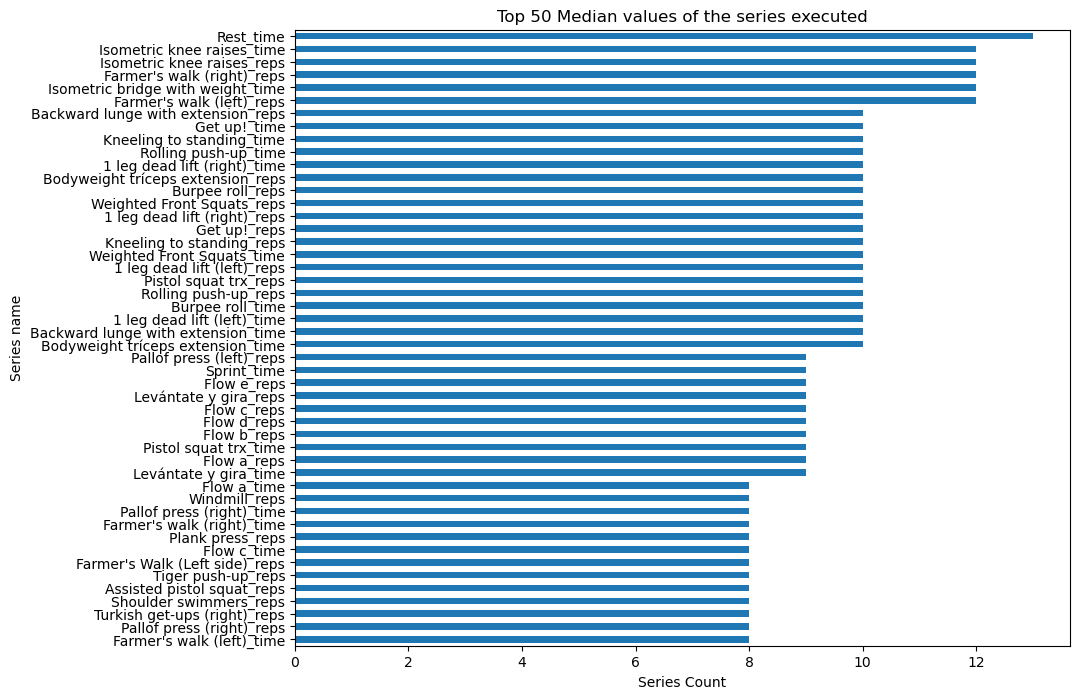

len_max_series:  884
Mountain climber plank_time        1.0
Frontal mountain climber_time      1.0
Kneeling squat_time                1.0
Diagonals_time                     1.0
Alternating shoulder press_time    1.0
Name: 50%, dtype: float64


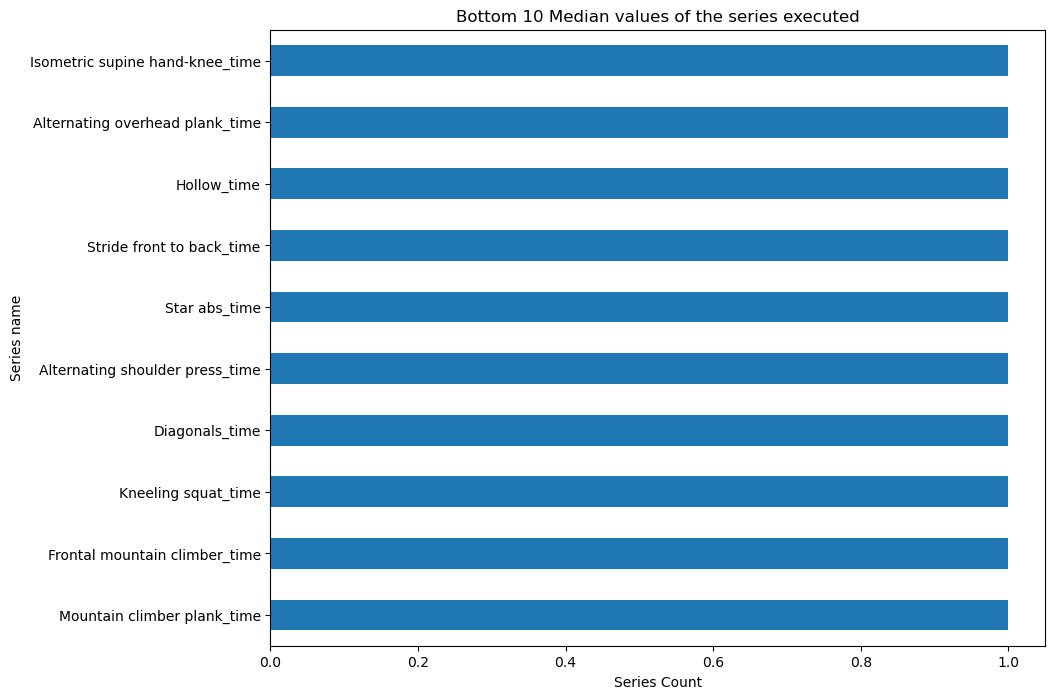

total_count_of_series_time         35.0
total_count_of_series_reps         23.0
Rest_time                          13.0
Isometric knee raises_time         12.0
Isometric knee raises_reps         12.0
                                   ... 
Hollow_time                         1.0
Alternating overhead plank_time     1.0
Isometric supine hand-knee_time     1.0
Alternate Superman_time             1.0
Chest expansions_reps               1.0
Name: 50%, Length: 884, dtype: float64

In [24]:
# Top 10 values
words_to_include = ['_time$', '_reps$']

range_values = (2,50)

plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Top ' + str(range_values[1]) + ' Median values of the series executed',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include, ascending = True)

# Bottom 10 values
words_to_include = ['_time$', '_reps$']

range_values = (872,882)

plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of the series executed',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of repetitions per exercise

len_max_series:  3352
Jump rope_reps_2    100.0
Jump rope_reps_6    100.0
Jump rope_reps_4    100.0
Jump rope_reps_1    100.0
Jump rope_reps_5    100.0
Name: 50%, dtype: float64


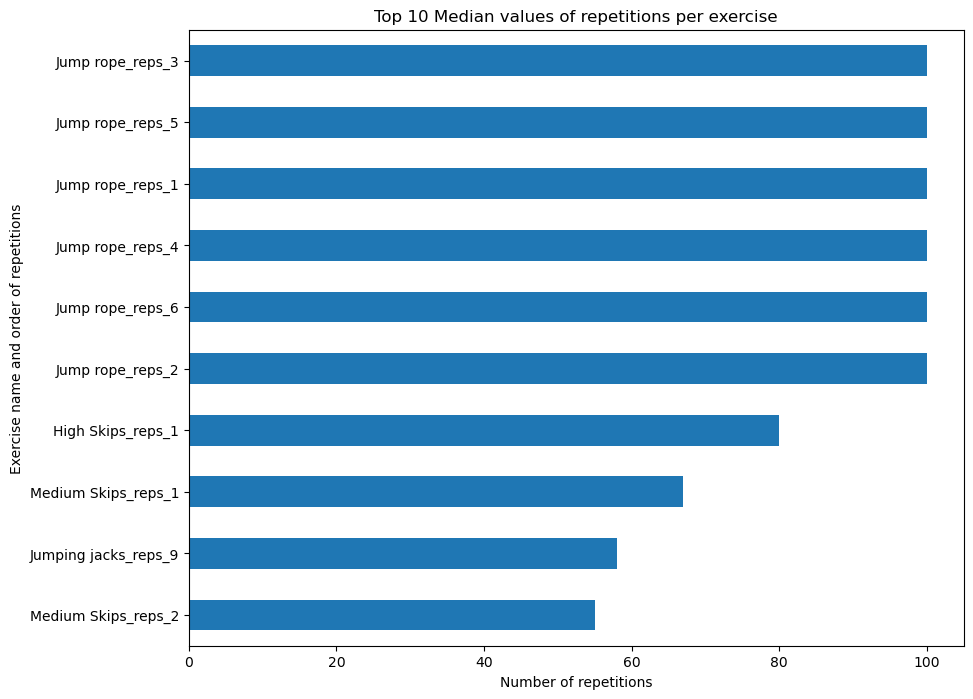

len_max_series:  3352
Bulgarian squat_reps_12    1.0
Rest_reps_69               1.0
Rest_reps_7                1.0
Rest_reps_51               1.0
Rest_reps_8                1.0
Name: 50%, dtype: float64


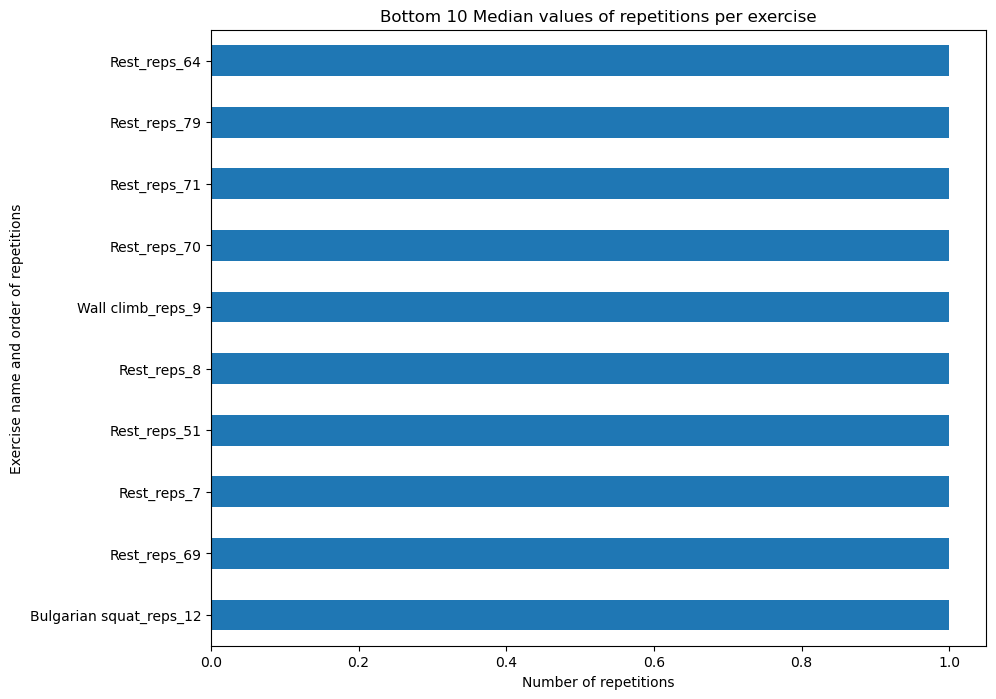

Jump rope_reps_2     100.0
Jump rope_reps_6     100.0
Jump rope_reps_4     100.0
Jump rope_reps_1     100.0
Jump rope_reps_5     100.0
                     ...  
Wall climb_reps_9      1.0
Rest_reps_70           1.0
Rest_reps_71           1.0
Rest_reps_79           1.0
Rest_reps_64           1.0
Name: 50%, Length: 3352, dtype: float64

In [25]:
#### Top 10 values

words_to_include = ['_reps_\d']

range_values = (0,10)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Top ' + str(range_values[1]) + ' Median values of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetitions'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

#### Bottom 10 values

words_to_include = ['_reps_\d']

range_values = (3342,3352)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetitions'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of time per exercise


len_max_series:  3550
Windmill with weight (right)_time_5        477.0
Jumping lunge_time_15                      419.0
Walk_time_1                                363.5
Tuck hold to tuck shoulder stand_time_1    338.0
Muscle-up 2_time_1                         303.0
Name: 50%, dtype: float64


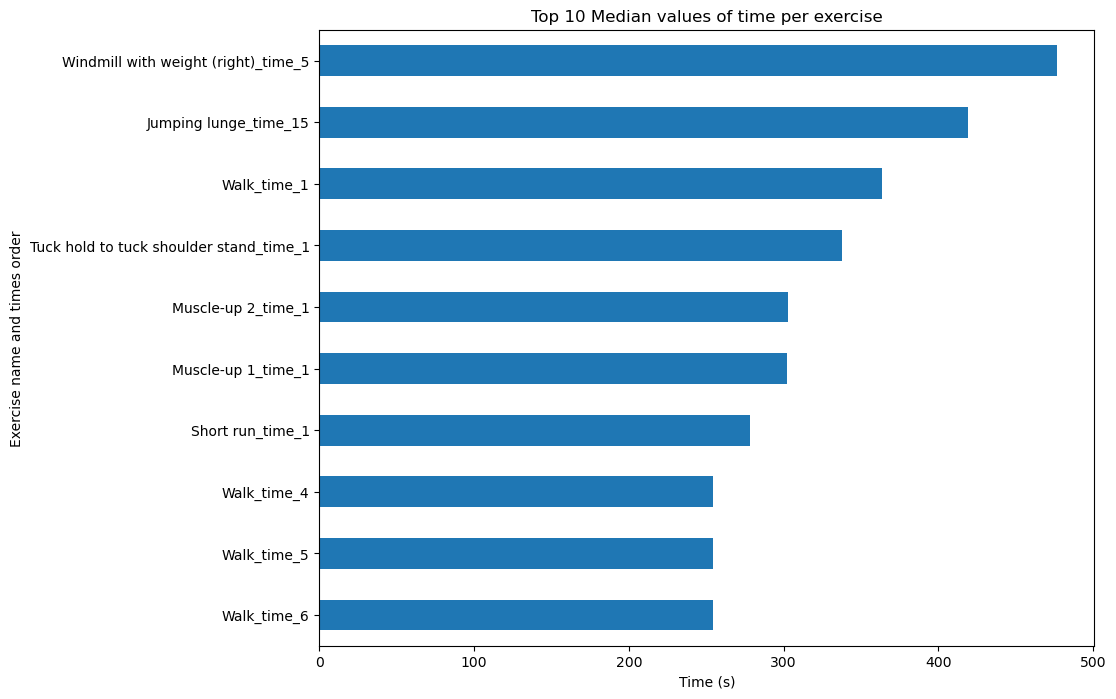

len_max_series:  3550
Vertical ring push-up 2_time_9              1.0
Rest_time_71                                1.0
1 leg bridge (right)_time_11                1.0
Bulgarian squat_time_9                      1.0
Jumping lunges with weight (left)_time_6    1.0
Name: 50%, dtype: float64


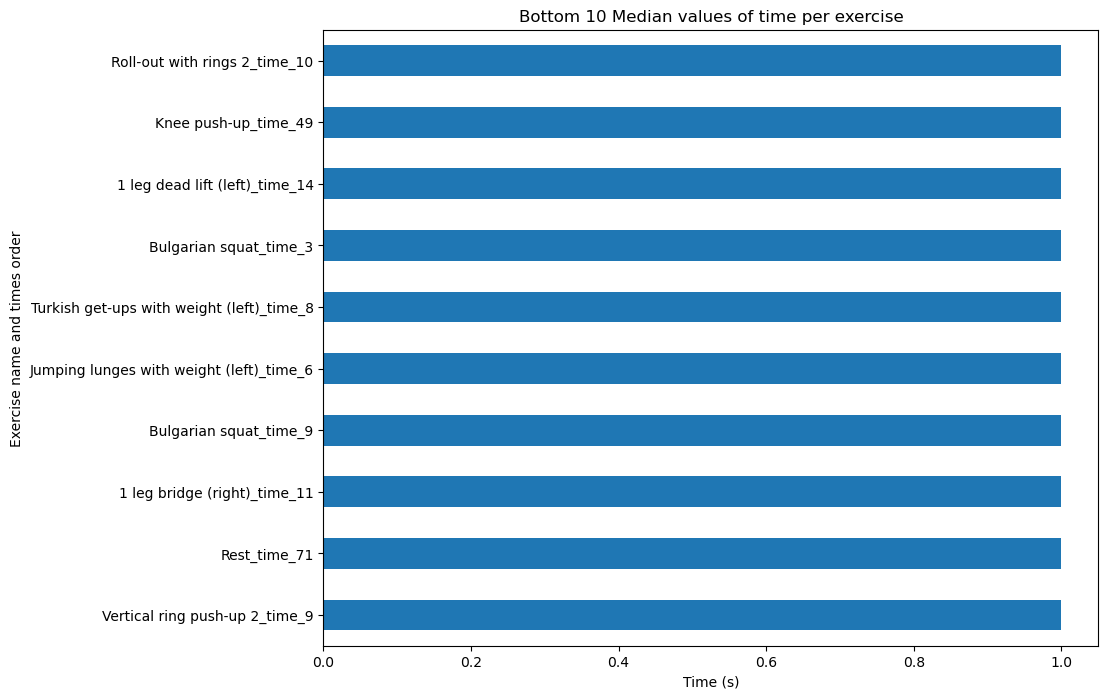

Windmill with weight (right)_time_5          477.0
Jumping lunge_time_15                        419.0
Walk_time_1                                  363.5
Tuck hold to tuck shoulder stand_time_1      338.0
Muscle-up 2_time_1                           303.0
                                             ...  
Turkish get-ups with weight (left)_time_8      1.0
Bulgarian squat_time_3                         1.0
1 leg dead lift (left)_time_14                 1.0
Knee push-up_time_49                           1.0
Roll-out with rings 2_time_10                  1.0
Name: 50%, Length: 3550, dtype: float64

In [26]:
# Top 10 values

words_to_include= ['_time_\d']

range_values = (0,10)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Top ' + str(range_values[1]) + ' Median values of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

# Bottom 10 values

words_to_include= ['_time_\d']

range_values = (3540,3550)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of the sum of repetitions per exercise

len_max_series:  430
Jump rope_sum_of_reps_per_exercise                400.0
Farmer's walk (left)_sum_of_reps_per_exercise     286.0
Farmer's walk (right)_sum_of_reps_per_exercise    258.0
Shoulder swimmers_sum_of_reps_per_exercise        240.0
Lunge with turns_sum_of_reps_per_exercise         202.0
Name: 50%, dtype: float64


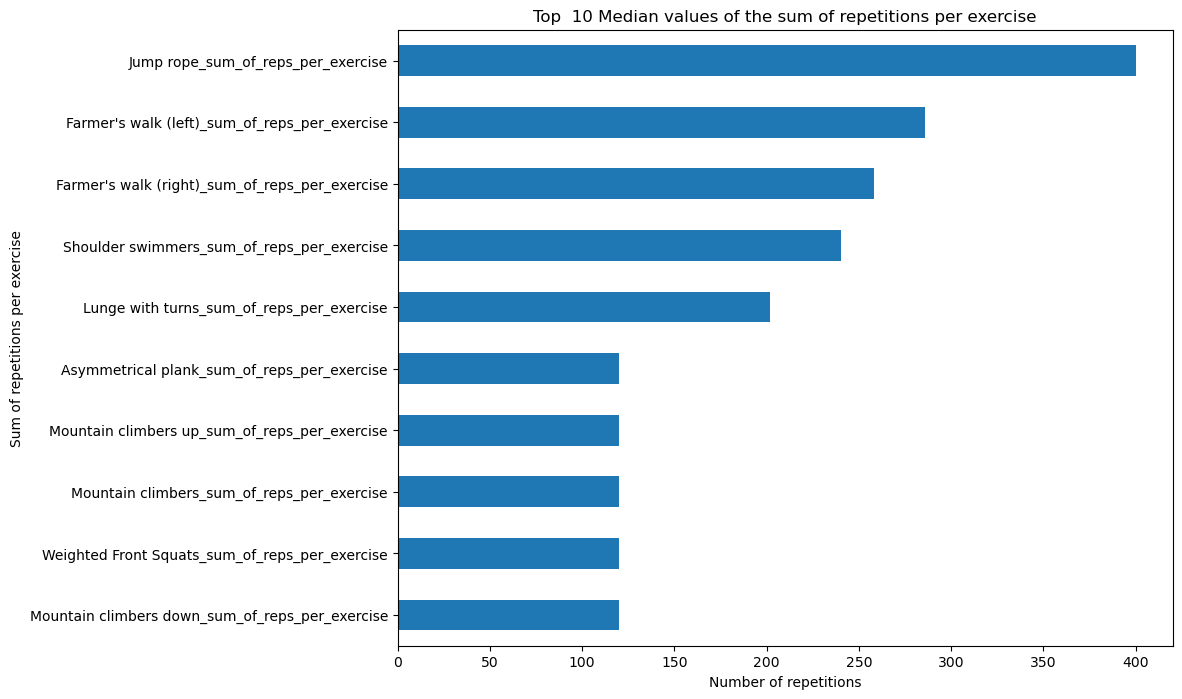

len_max_series:  430
Turkish get-ups (right)_sum_of_reps_per_exercise      8.0
Turkish get-ups (left)_sum_of_reps_per_exercise       8.0
Kneeling squat_sum_of_reps_per_exercise               8.0
Rest_sum_of_reps_per_exercise                         8.0
Thoracic rotations (left)_sum_of_reps_per_exercise    8.0
Name: 50%, dtype: float64


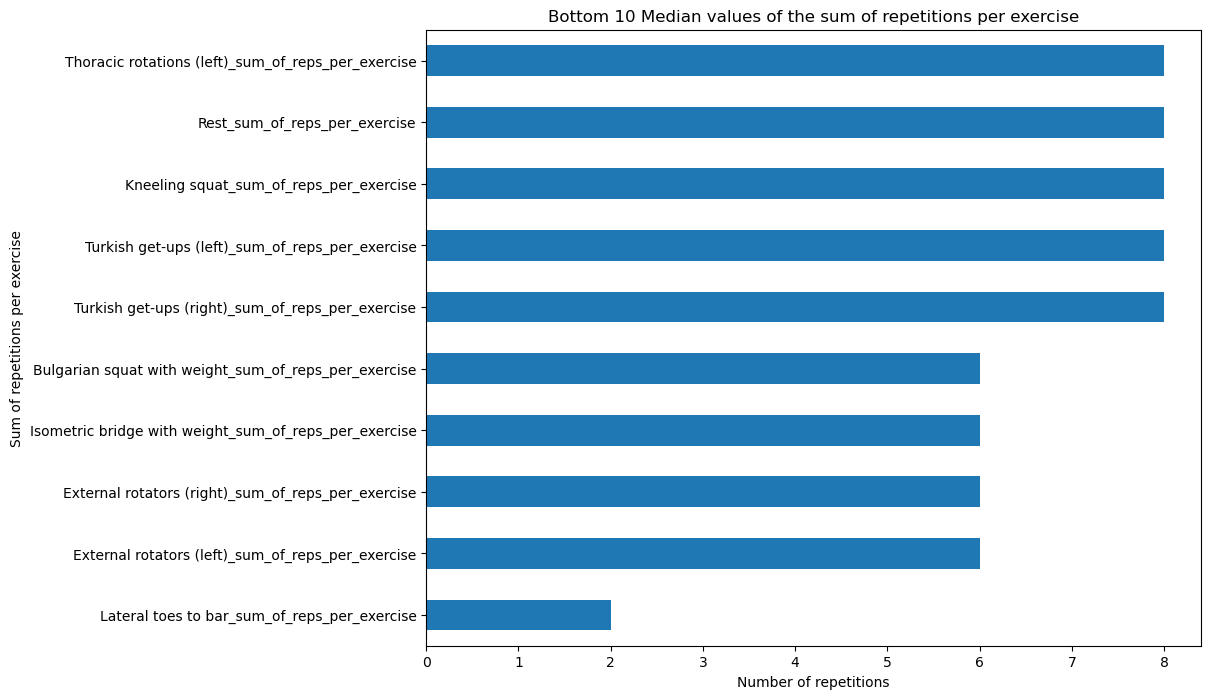

Jump rope_sum_of_reps_per_exercise                                  400.0
Farmer's walk (left)_sum_of_reps_per_exercise                       286.0
Farmer's walk (right)_sum_of_reps_per_exercise                      258.0
Shoulder swimmers_sum_of_reps_per_exercise                          240.0
Lunge with turns_sum_of_reps_per_exercise                           202.0
Mountain climbers down_sum_of_reps_per_exercise                     120.0
Weighted Front Squats_sum_of_reps_per_exercise                      120.0
Mountain climbers_sum_of_reps_per_exercise                          120.0
Mountain climbers up_sum_of_reps_per_exercise                       120.0
Asymmetrical plank_sum_of_reps_per_exercise                         120.0
Isometric bridge_sum_of_reps_per_exercise                           105.0
Pallof press (left)_sum_of_reps_per_exercise                        103.5
Underswitch_sum_of_reps_per_exercise                                100.0
Shoulder clean_sum_of_reps_per_exercis

In [27]:
# Top 10 values

words_to_include = ['_sum_of_reps_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top  ' + str(range_reps[1]) + ' Median values of the sum of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}
barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

# Bottom 10 values
words_to_include = ['_sum_of_reps_per_exercise']

range_reps = (420,430)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of the sum of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}
barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of the sum of time per exercise

len_max_series:  452
Walk_sum_of_time_per_exercise                1207.0
Short run_sum_of_time_per_exercise            948.0
Rolling push-up_sum_of_time_per_exercise      659.0
Skipping_sum_of_time_per_exercise             479.0
Lunge with turns_sum_of_time_per_exercise     473.0
Name: 50%, dtype: float64


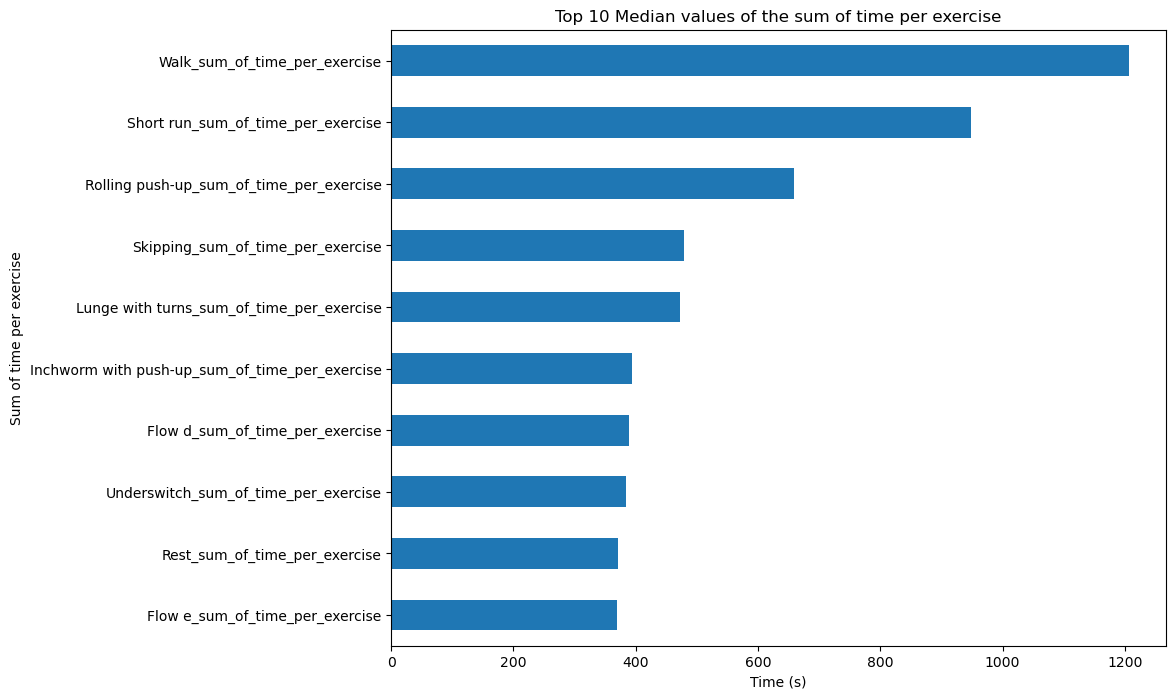

len_max_series:  452
Windmill with weight (left)_sum_of_time_per_exercise      13.5
Thruster with KB (left)_sum_of_time_per_exercise          12.0
Assisted pistol squat (left)_sum_of_time_per_exercise     11.0
Unilateral transport (left)_sum_of_time_per_exercise      10.0
Thruster with kettlebell left_sum_of_time_per_exercise     8.0
Name: 50%, dtype: float64


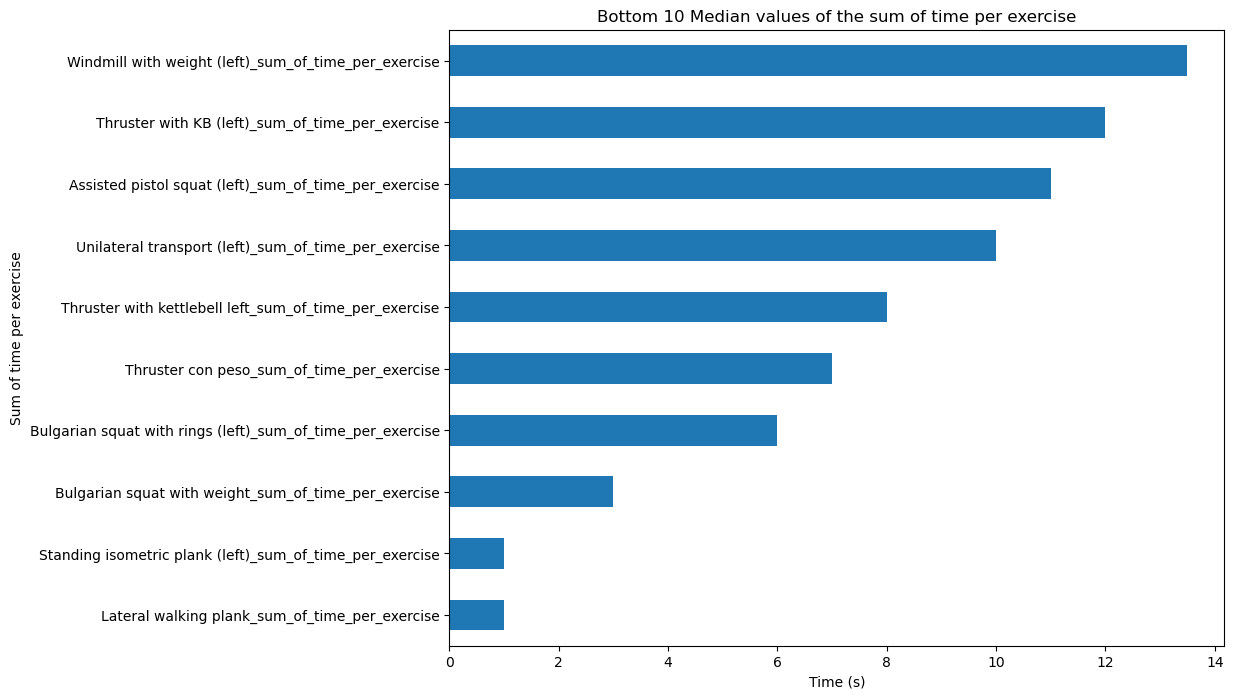

Walk_sum_of_time_per_exercise                                       1207.0
Short run_sum_of_time_per_exercise                                   948.0
Rolling push-up_sum_of_time_per_exercise                             659.0
Skipping_sum_of_time_per_exercise                                    479.0
Lunge with turns_sum_of_time_per_exercise                            473.0
Inchworm with push-up_sum_of_time_per_exercise                       394.0
Flow d_sum_of_time_per_exercise                                      388.5
Underswitch_sum_of_time_per_exercise                                 384.0
Rest_sum_of_time_per_exercise                                        371.0
Flow e_sum_of_time_per_exercise                                      370.0
Burpee roll_sum_of_time_per_exercise                                 370.0
Flow b_sum_of_time_per_exercise                                      351.0
Push-up with roll_sum_of_time_per_exercise                           342.0
Tuck hold to tuck shoulde

In [28]:
# Top 10 values
words_to_include = ['_sum_of_time_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' Median values of the sum of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

# Bottom 10 values
words_to_include = ['_sum_of_time_per_exercise']

range_reps = (442,452)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of the sum of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

In [29]:
df_series_recalculated.Rest_time

3737      32.0
5830      15.0
17048     17.0
17351      3.0
715926    19.0
          ... 
746183     0.0
746178    21.0
746199     9.0
746468    29.0
746205    10.0
Name: Rest_time, Length: 46192, dtype: float64

## Max and Median of cummulative values

In [30]:
df_describe_commulative_values = df_describe_zeros_excluded.loc[:,columns_to_remove].drop(columns=['user_programs_user_id'])

In [31]:
df_describe_commulative_values.reset_index(inplace=True)

In [32]:
describe_num_df = df_describe_commulative_values[df_describe_commulative_values['index'] != 'count']

In [33]:
describe_num_df

,index,sum_of_reps,sum_of_time,session_executions_summary_effort,session_executions_summary_points,session_executions_summary_total_kcal,session_executions_summary_value_of_session
1,mean,5.556934e+04,1328.321896,6.109858,106.245670,130.057477,3.884729
2,std,9.928625e+06,906.775313,2.494777,33.966978,228.152118,1.443010
3,min,1.000000e+00,2.000000,1.000000,50.000000,1.000000,1.000000
4,25%,1.510000e+02,856.000000,5.000000,100.000000,72.000000,3.000000
5,50%,2.400000e+02,1293.000000,5.000000,100.000000,104.000000,4.000000
6,75%,3.300000e+02,1682.000000,7.000000,100.000000,150.000000,4.000000
7,max,2.111101e+09,80587.000000,136.000000,2300.000000,12164.000000,74.000000


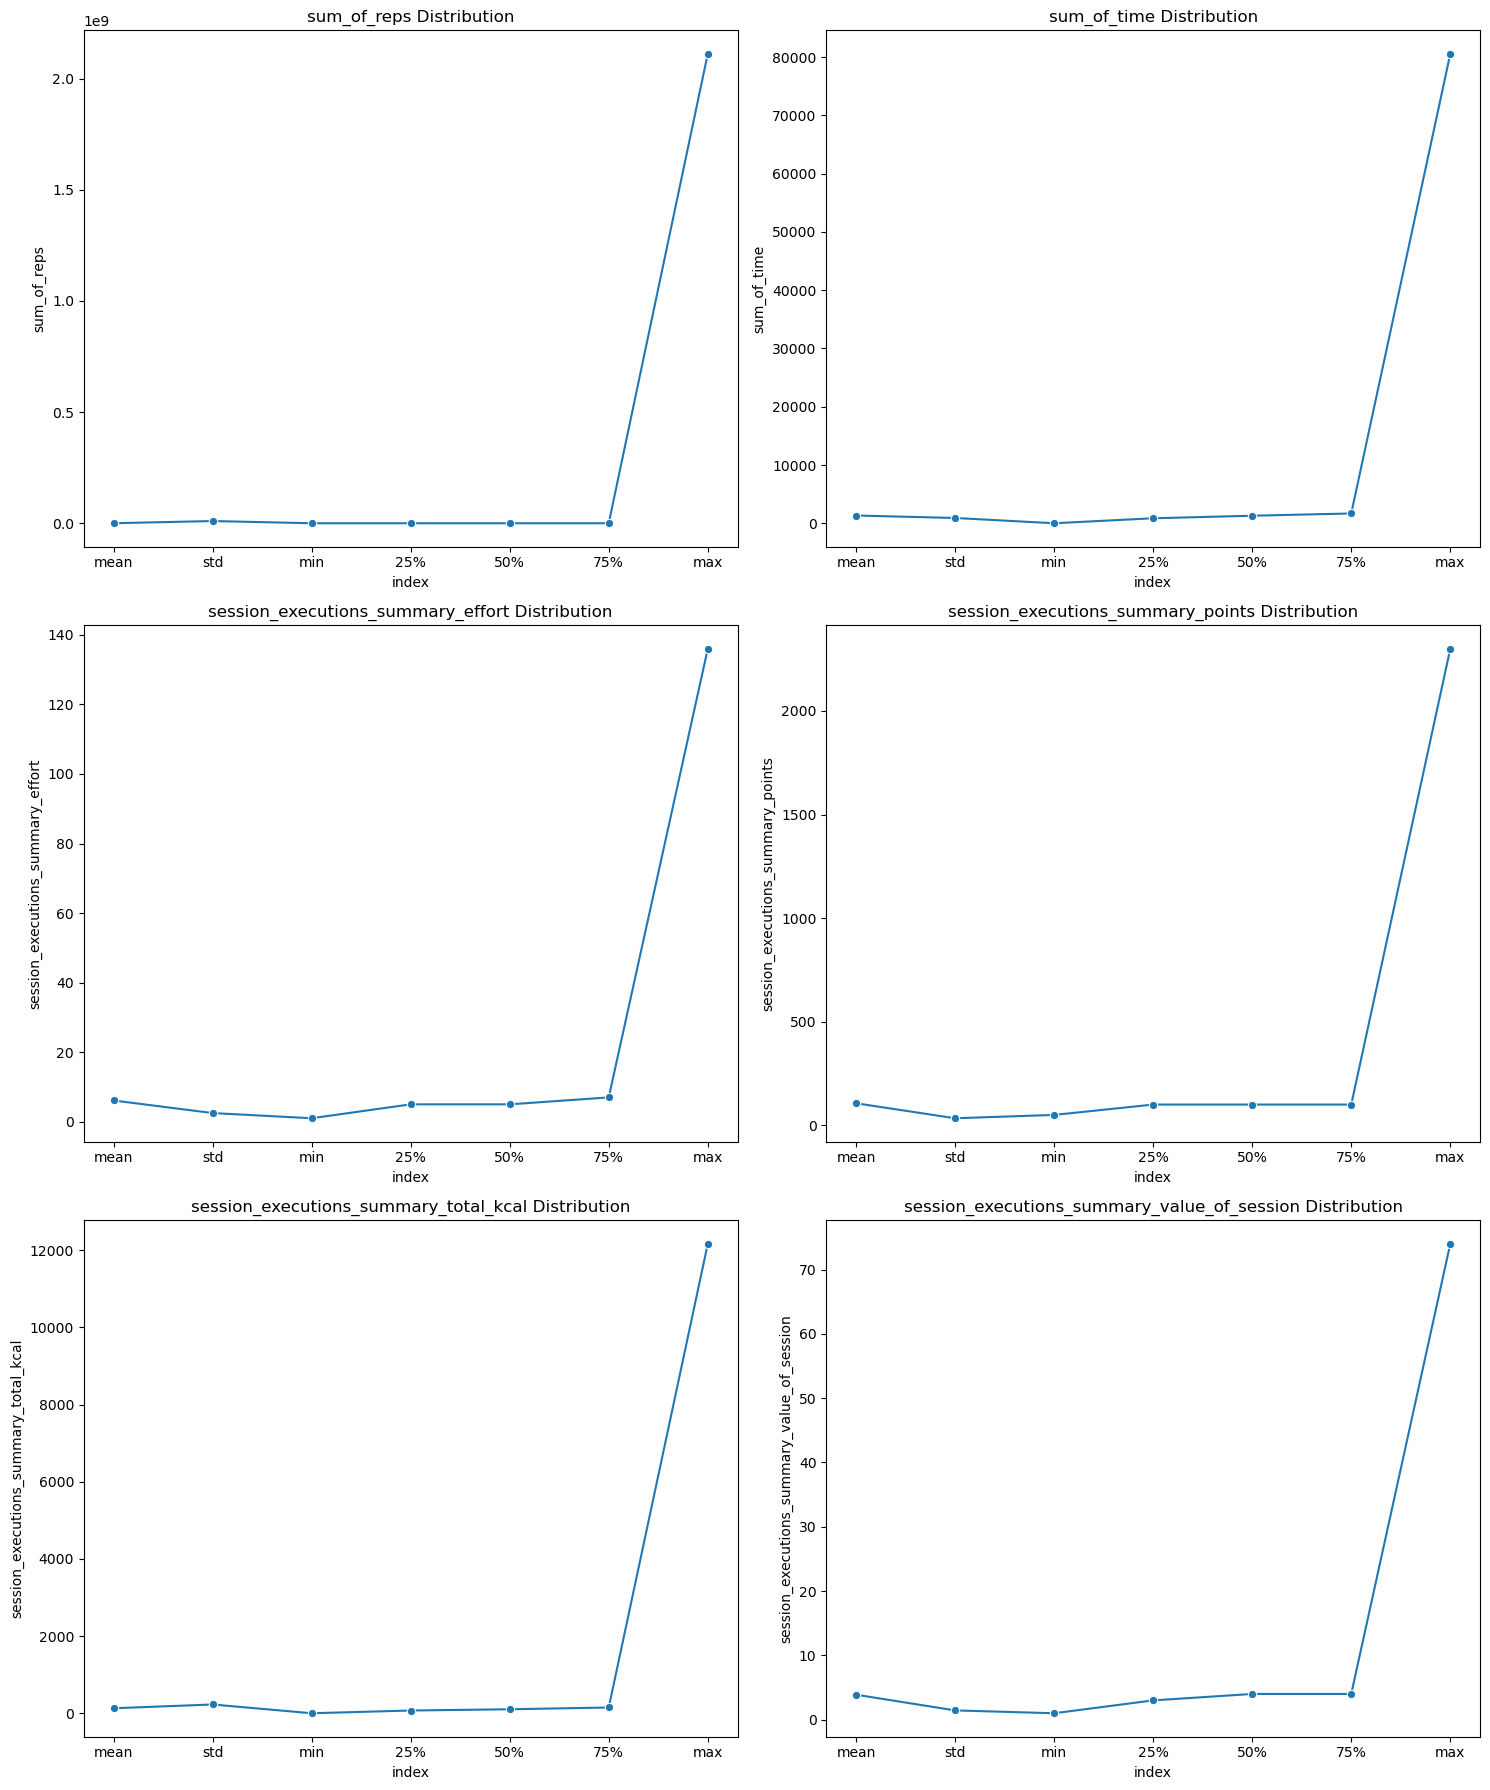

In [34]:
num_cols = len(describe_num_df.columns) - 1  # Exclude the 'index' column
num_rows = (num_cols + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6*num_rows))

# Plot each numerical column as a subplot
row_plot = 0
col_plot = 0

for idx, col in enumerate(describe_num_df.columns):
    idx = idx - 1
    if col == 'index':
        continue  

    sns.lineplot(x='index', y=col, data=describe_num_df, ax=axes[row_plot,col_plot], marker="o")
    axes[row_plot,col_plot].set_title(f'{col} Distribution')

    if idx%2 ==0:
       col_plot = col_plot + 1
    else:
       row_plot = row_plot + 1
       col_plot = 0 

# Adjust layout to prevent overlapping
plt.tight_layout()

### Sum of Reps

Text(0, 0.5, 'Index of sessions')

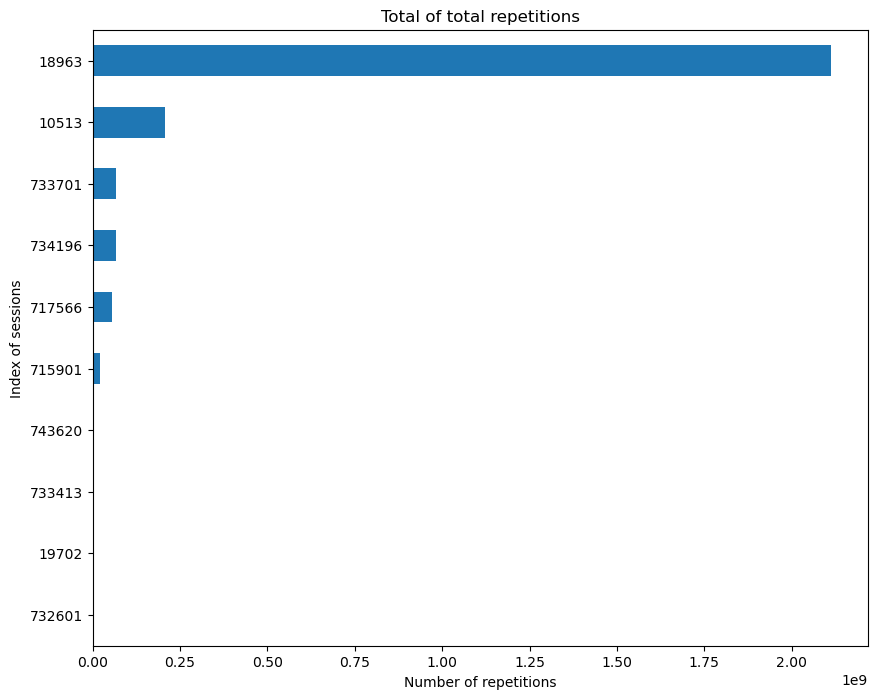

In [35]:
range_max = (0,10)
top_sum_of_reps = df_series_recalculated['sum_of_reps'].sort_values(ascending=False)
top_sum_of_reps = top_sum_of_reps[range_max[0]:range_max[1]]
# Sorting and plotting
ax_reps = top_sum_of_reps.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax_reps.set_title('Total of total repetitions')
ax_reps.set_xlabel('Number of repetitions')
ax_reps.set_ylabel('Index of sessions')

### Total Time

Text(0, 0.5, 'Index of sessions')

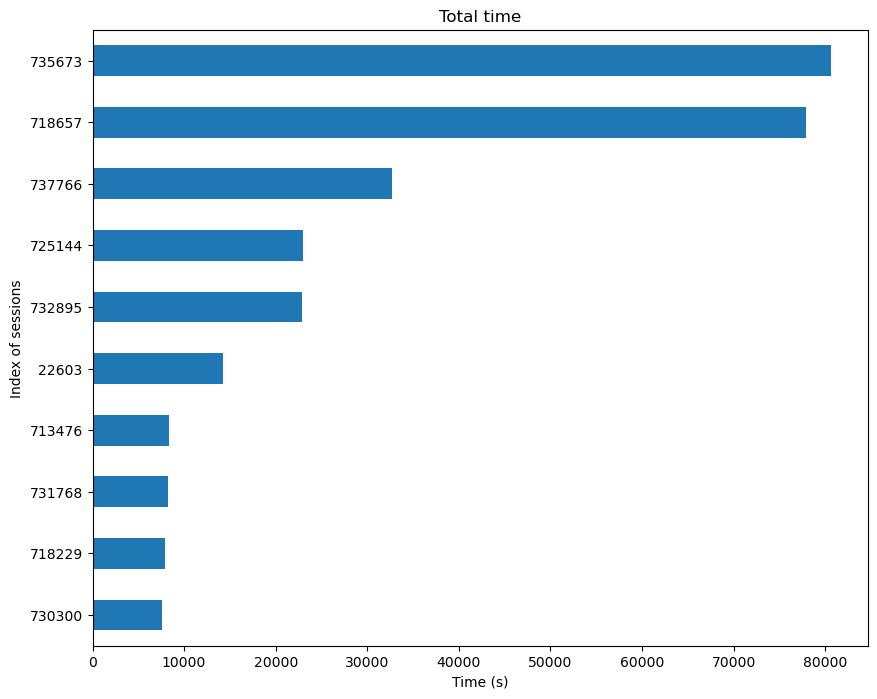

In [37]:
range_max = (0,10)
top_sum_of_time = df_series_recalculated['sum_of_time'].sort_values(ascending=False)
top_sum_of_time = top_sum_of_time[range_max[0]:range_max[1]]

# Sorting and plotting
ax = top_sum_of_time.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax.set_title('Total time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Index of sessions')

---
---
---
---

#### Histogram of Series Distribution per Training Session

This chart is a histogram that shows how training sessions are distributed according to the number of series performed. Each bar represents the number of sessions that have a specific number of series, allowing for the visualization of the frequency of different amounts of series per session.

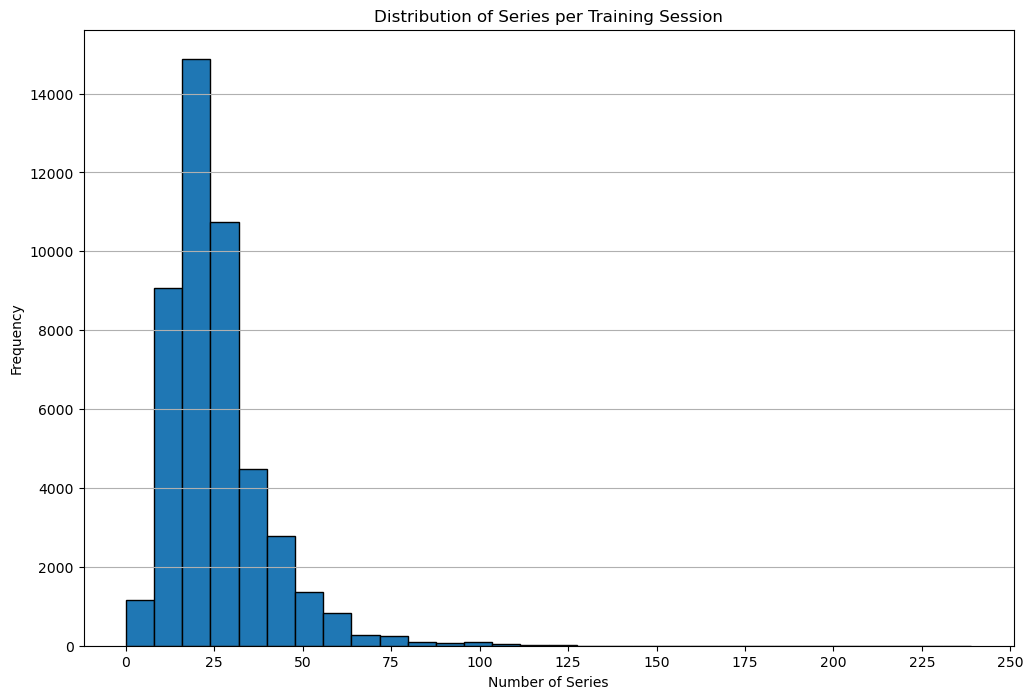

In [361]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
plt.hist(df_series_recalculated['total_count_of_series_reps'], bins=30, edgecolor='black')
plt.xlabel('Number of Series')
plt.ylabel('Frequency')
plt.title('Distribution of Series per Training Session')

max_series = df_series_recalculated['total_count_of_series_reps'].max()
plt.xticks(np.arange(0, max_series + 25, 25))

plt.grid(axis='y')
plt.show()


#### Histogram of the Distribution of Total Time Spent on Exercises per Training Session

The displayed graph is a histogram that shows the distribution of the total time spent on exercises per training session, measured in minutes. The x-axis represents the total time spent, while the y-axis shows the frequency of sessions that fall within each time range. By setting an x-axis limit of 180 minutes (3 hours), the graph excludes outliers to provide a clearer view of the typical training session durations. The histogram helps in understanding the common duration of training sessions, with the average session time being around 22 minutes when ignoring values greater than 3 hours.

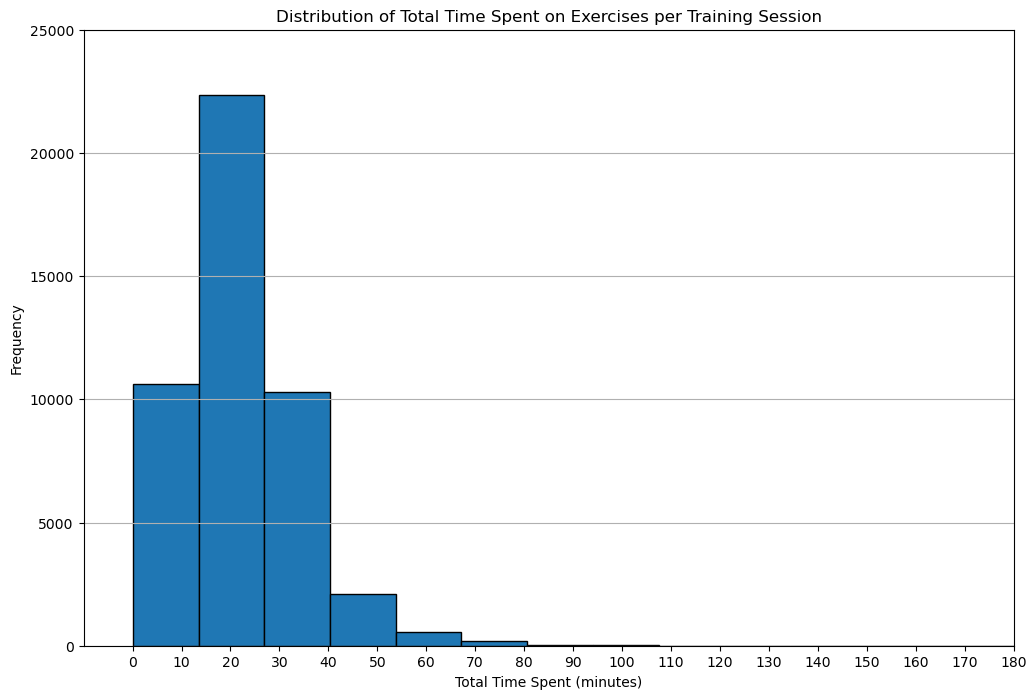

The Maximum training time in minutes is: 1343.1166666666666 minutes
Mean of training time (in minutes) ignoring values greater than 2 hours: 22.04 minutes

It is important to notice that for a better interpretability of the data it is necessary to put a limit 
in the x-axis in order to avoid outliers and have a better comprehension of the data. 
So for that, it can be observed that the mean distribution of training time is around 22 minutes per training session.


In [112]:
plt.figure(figsize=(12, 8))
plt.hist(df_series_recalculated['sum_of_time'] / 60, bins=100, edgecolor='black')
plt.xlabel('Total Time Spent (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Time Spent on Exercises per Training Session')

max_time = df_series_recalculated['sum_of_time'].max() / 60
plt.xticks(np.arange(0, max_time + 10, 10))

plt.ylim(0, 25000)
plt.xlim(-10, 180)
plt.grid(axis='y')
plt.show()

print(f'The Maximum training time in minutes is:', max_time, 'minutes')

# Filter out rows where sum_of_time is greater than 120 minutes (2 hours)
filtered_df = df_series_recalculated[df_series_recalculated['sum_of_time'] / 60 <= 120]
mean_sum_of_time = (filtered_df['sum_of_time'] / 60).mean()

print(f'Mean of training time (in minutes) ignoring values greater than 2 hours: {mean_sum_of_time:.2f} minutes')

print('\nIt is important to notice that for a better interpretability of the data it is necessary to put a limit \nin the x-axis in order to avoid outliers and have a better comprehension of the data. \nSo for that, it can be observed that the mean distribution of training time is around 22 minutes per training session.')


#### Histogram of the Distribution of Rest Time per Training Session

The displayed graph is a histogram that shows the distribution of rest time per training session, measured in minutes. The x-axis represents the rest time, while the y-axis shows the frequency of sessions that fall within each rest time range. By setting an x-axis limit of 100 minutes, the graph excludes outliers to provide a clearer view of the typical rest durations during training sessions. The histogram helps in understanding the common rest periods, with the average rest time being around 5.64 minutes when ignoring values greater than 60 minutes.

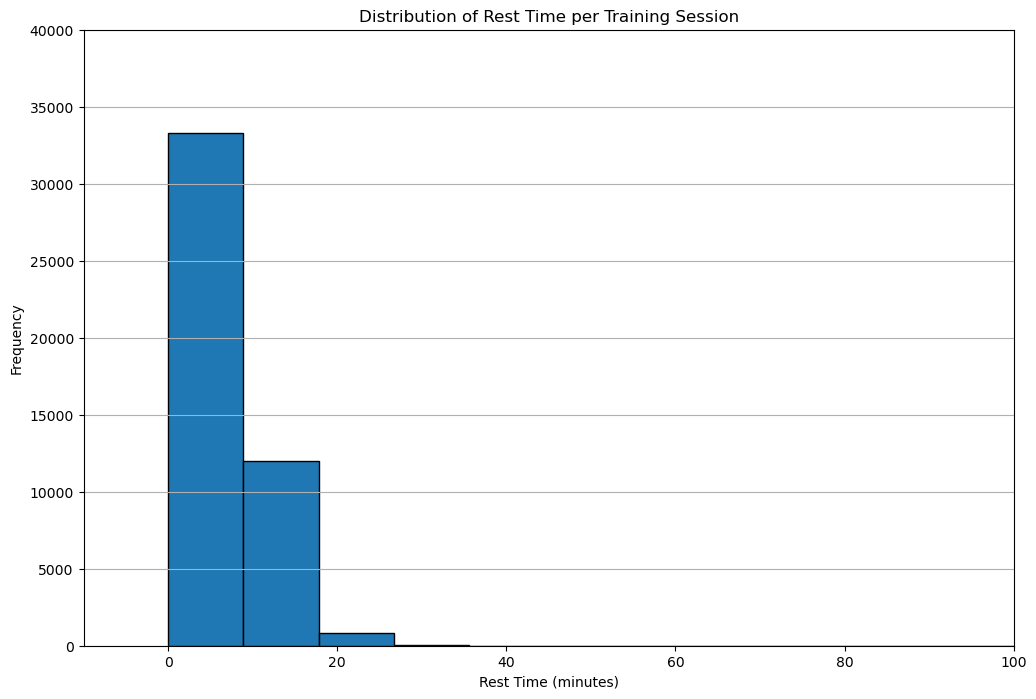

The Maximum training time in minutes is: 712.2666666666667 minutes
Mean of rest time (in minutes) ignoring values greater than 1 hour: 5.64 minutes

It is important to notice that for a better interpretability of the data it is necessary to put a limit 
in the x-axis in order to avoid outliers and have a better comprehension of the data. 
So for that, it can be observed that the mean distribution of rest time is around 5.64 minutes per training session.


In [116]:
plt.figure(figsize=(12, 8))
plt.hist(df_series_recalculated['Rest_sum_of_time_per_exercise'] / 60, bins=80, edgecolor='black')
plt.xlabel('Rest Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Rest Time per Training Session')

max_rest_time = df_series_recalculated['Rest_sum_of_time_per_exercise'].max() / 60
plt.xticks(np.arange(0, max_rest_time + 20, 20))

plt.ylim(0, 40000)
plt.xlim(-10, 100)
plt.grid(axis='y')
plt.show()

print(f'The Maximum training time in minutes is:', max_rest_time, 'minutes')

# Filter out rows where rest time is greater than 60 minutes (1 hour)
filtered_df = df_series_recalculated[df_series_recalculated['Rest_sum_of_time_per_exercise'] / 60 <= 60]
mean_rest_time = (filtered_df['Rest_sum_of_time_per_exercise'] / 60).mean()

print(f'Mean of rest time (in minutes) ignoring values greater than 1 hour: {mean_rest_time:.2f} minutes')

print('\nIt is important to notice that for a better interpretability of the data it is necessary to put a limit \nin the x-axis in order to avoid outliers and have a better comprehension of the data. \nSo for that, it can be observed that the mean distribution of rest time is around 5.64 minutes per training session.')


#### Distribution of Training Frequency from June 2021 to May 2022

This bar chart shows the number of training sessions conducted each month from June 2021 to May 2022. The x-axis represents each month and year, while the y-axis indicates the number of training sessions. The graph provides insight into the monthly training patterns, revealing the highest frequency of training sessions and the overall distribution throughout the specified period. The mean training frequency per month is also displayed for better understanding of the data.

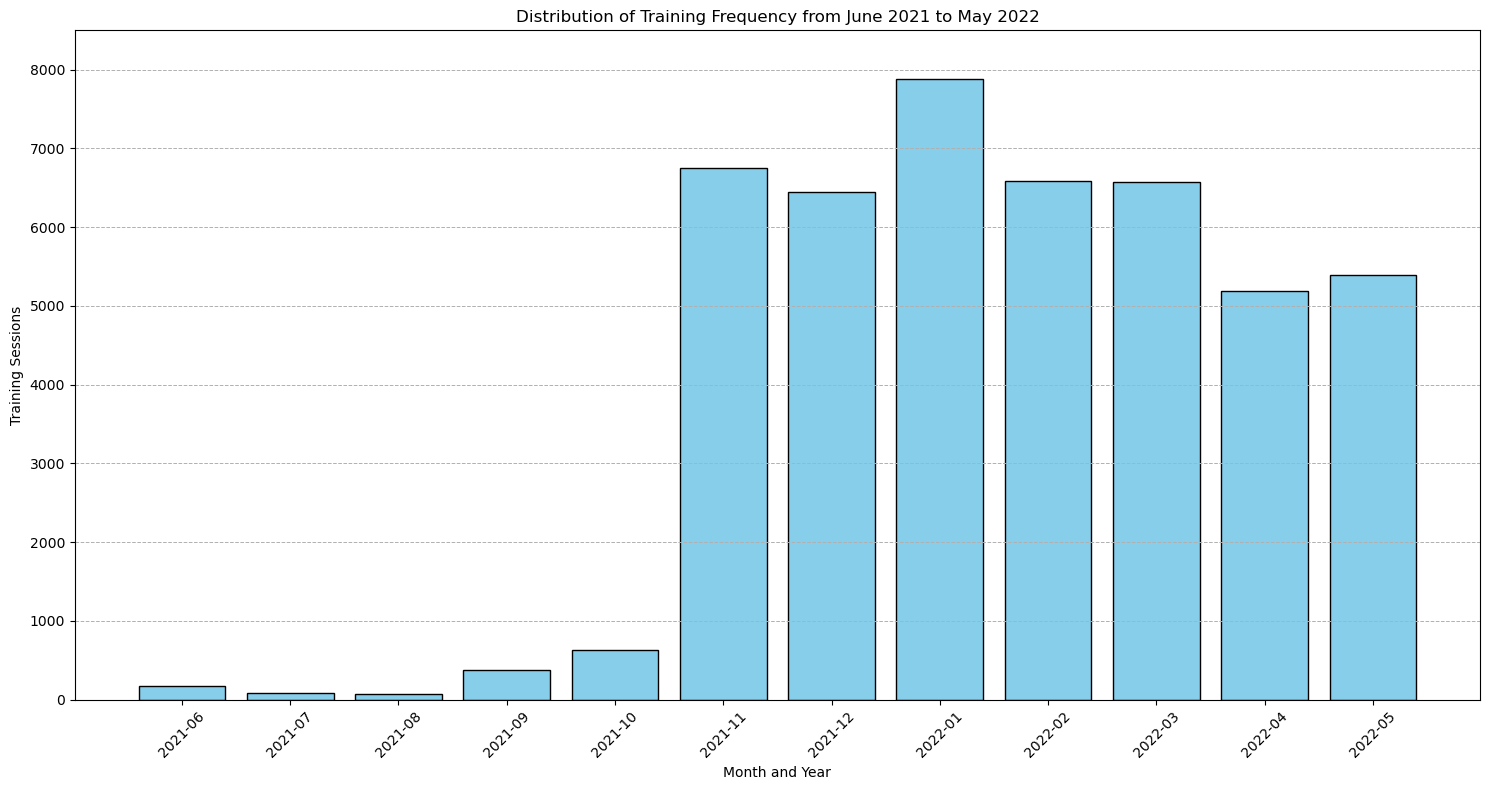

The maximum training frequency in a month is: 7884 training sessions
The mean training frequency per month is:
month
2021-06     172
2021-07      87
2021-08      70
2021-09     378
2021-10     628
2021-11    6753
2021-12    6441
2022-01    7884
2022-02    6586
2022-03    6569
2022-04    5189
2022-05    5396
Freq: M, dtype: int64


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])

# Filter data from June 2021 to May 2022
filtered_df = df_series_recalculated[(df_series_recalculated['date'] >= '2021-06-01') & (df_series_recalculated['date'] <= '2022-05-31')]

# Calculate the number of training sessions per month
filtered_df['month'] = filtered_df['date'].dt.to_period('M')
training_frequency_per_month = filtered_df.groupby('month').size()

# Plotting
plt.figure(figsize=(15, 8))
plt.bar(training_frequency_per_month.index.astype(str), training_frequency_per_month.values, edgecolor='black', color='skyblue', width=0.8)
plt.xlabel('Month and Year')
plt.ylabel('Training Sessions')
plt.title('Distribution of Training Frequency from June 2021 to May 2022')
plt.ylim(0, training_frequency_per_month.max() + 100)

# Format x-axis with month and year
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.ylim(0, 8500)
plt.tight_layout()
plt.show()

print(f'The maximum training frequency in a month is: {training_frequency_per_month.max()} training sessions')
print('The mean training frequency per month is:')
print(training_frequency_per_month)


#### Distribution of Training Frequency per Week from December 2021 to February 2022

This bar chart displays the number of training sessions conducted each week from December 2021 to February 2022. The x-axis represents each week, while the y-axis indicates the number of training sessions. The graph provides a detailed view of the weekly training patterns during these three months, showing the highest frequency of training sessions and the overall weekly distribution. The maximum and mean training frequencies per week are also calculated to give a better understanding of the training intensity during this period.

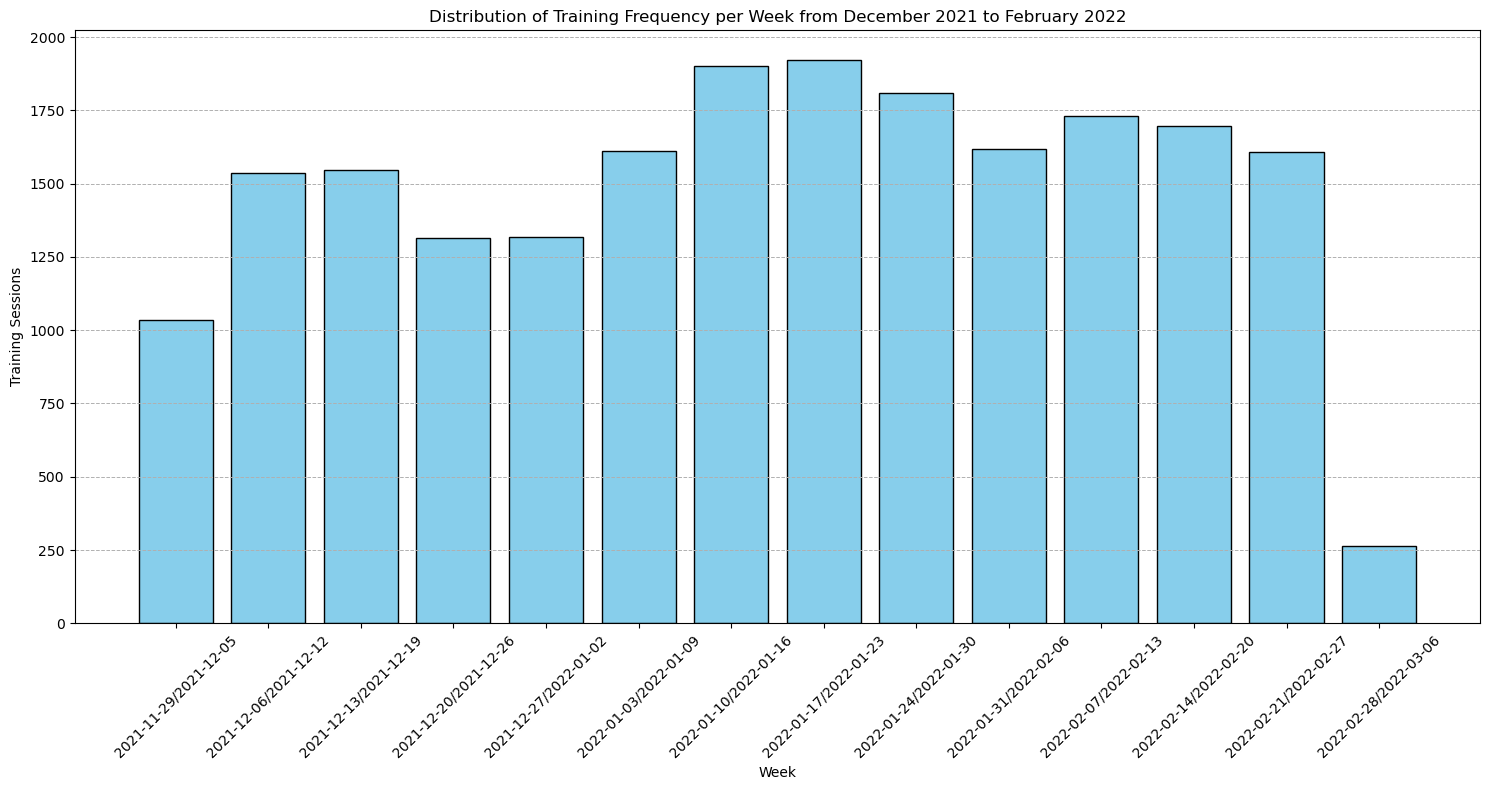

The maximum training frequency in a week is: 1923 training sessions
The mean training frequency per week is:
week
2021-11-29/2021-12-05    1036
2021-12-06/2021-12-12    1536
2021-12-13/2021-12-19    1547
2021-12-20/2021-12-26    1314
2021-12-27/2022-01-02    1319
2022-01-03/2022-01-09    1613
2022-01-10/2022-01-16    1901
2022-01-17/2022-01-23    1923
2022-01-24/2022-01-30    1809
2022-01-31/2022-02-06    1617
2022-02-07/2022-02-13    1730
2022-02-14/2022-02-20    1695
2022-02-21/2022-02-27    1608
2022-02-28/2022-03-06     263
Freq: W-SUN, dtype: int64


In [96]:
import warnings
warnings.filterwarnings("ignore")

df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])

# Filter data for December 2021, January 2022, and February 2022
filtered_df = df_series_recalculated[(df_series_recalculated['date'] >= '2021-12-01') & (df_series_recalculated['date'] <= '2022-02-28')]

# Calculate the number of training sessions per week
filtered_df['week'] = filtered_df['date'].dt.to_period('W')
training_frequency_per_week = filtered_df.groupby('week').size()

# Plotting
plt.figure(figsize=(15, 8))
plt.bar(training_frequency_per_week.index.astype(str), training_frequency_per_week.values, edgecolor='black', color='skyblue', width=0.8)
plt.xlabel('Week')
plt.ylabel('Training Sessions')
plt.title('Distribution of Training Frequency per Week from December 2021 to February 2022')
plt.ylim(0, training_frequency_per_week.max() + 100)

# Format x-axis with weeks
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

print(f'The maximum training frequency in a week is: {training_frequency_per_week.max()} training sessions')
print('The mean training frequency per week is:')
print(training_frequency_per_week)

---

## Analysis Over Time

#### Total Number of Series per Training Session Over Time

The graph aims to visualize the total number of series per training session over time, tracking the progression or changes in training intensity or frequency. By plotting the summed series counts against each session's date, it helps to identify trends, such as increases in workout intensity or periods of rest, as well as any seasonal or periodic patterns in training behavior. This visualization is particularly useful for monitoring training loads and planning adjustments to workout schedules based on past activity.

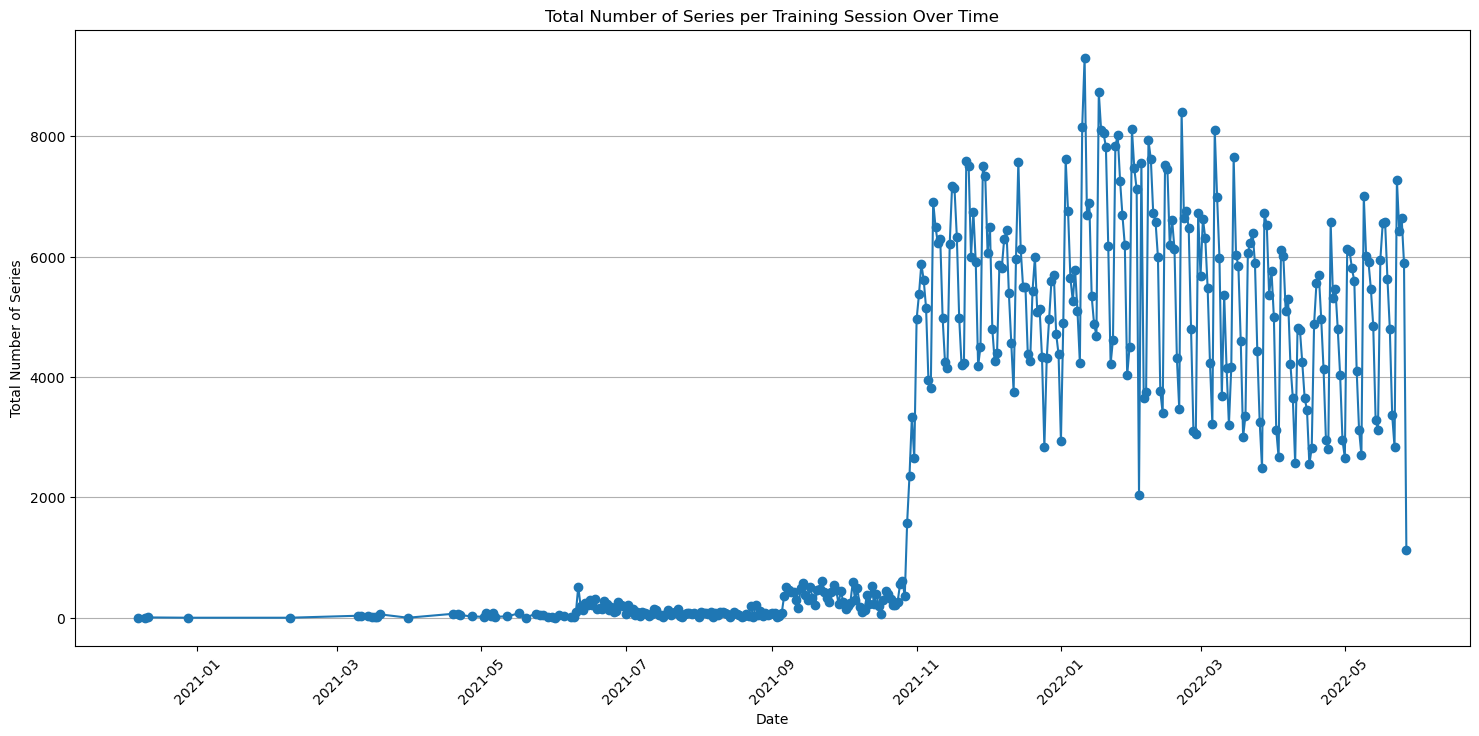

In [264]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])  
series_over_time = df_series_recalculated.groupby('date')['total_count_of_series_reps'].sum()

plt.figure(figsize=(18, 8))
plt.plot(series_over_time.index, series_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Number of Series')
plt.title('Total Number of Series per Training Session Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

#### Total Repetitions per Training Session Over Time

This graph is designed to illustrate the total number of repetitions performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

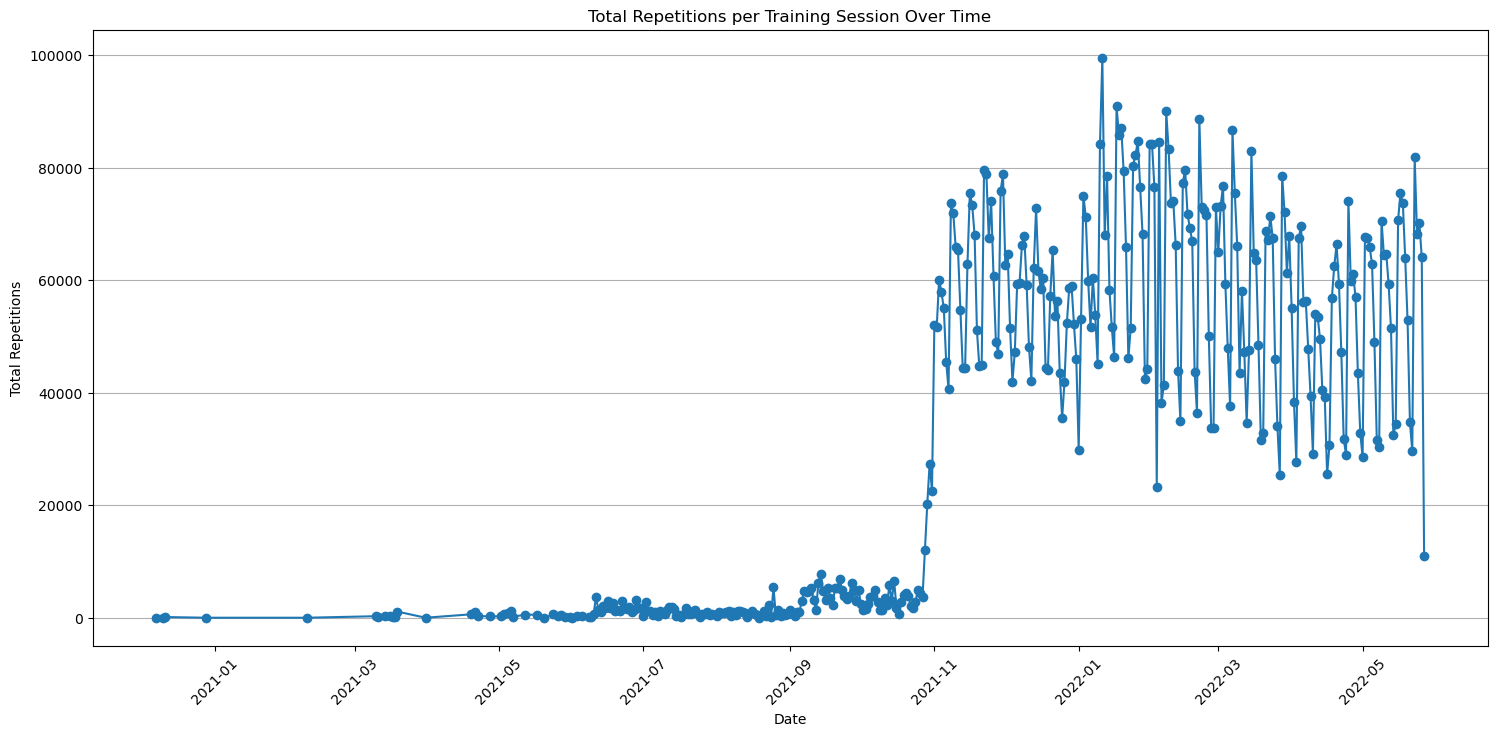

In [124]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])  # Ensure 'date' column is datetime type

# Filter out rows where 'sum_of_reps' is greater than 50000
filtered_df = df_series_recalculated[df_series_recalculated['sum_of_reps'] <= 5000]

# Group by date and sum the 'sum_of_reps'
reps_over_time = filtered_df.groupby('date')['sum_of_reps'].sum()

plt.figure(figsize=(18, 8))
plt.plot(reps_over_time.index, reps_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Repetitions')
plt.title('Total Repetitions per Training Session Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


In [126]:
df_series_recalculated.shape

(46192, 8677)

#### Total Duration per Training Session Over Time

This graph is designed to illustrate the total time performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training time intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

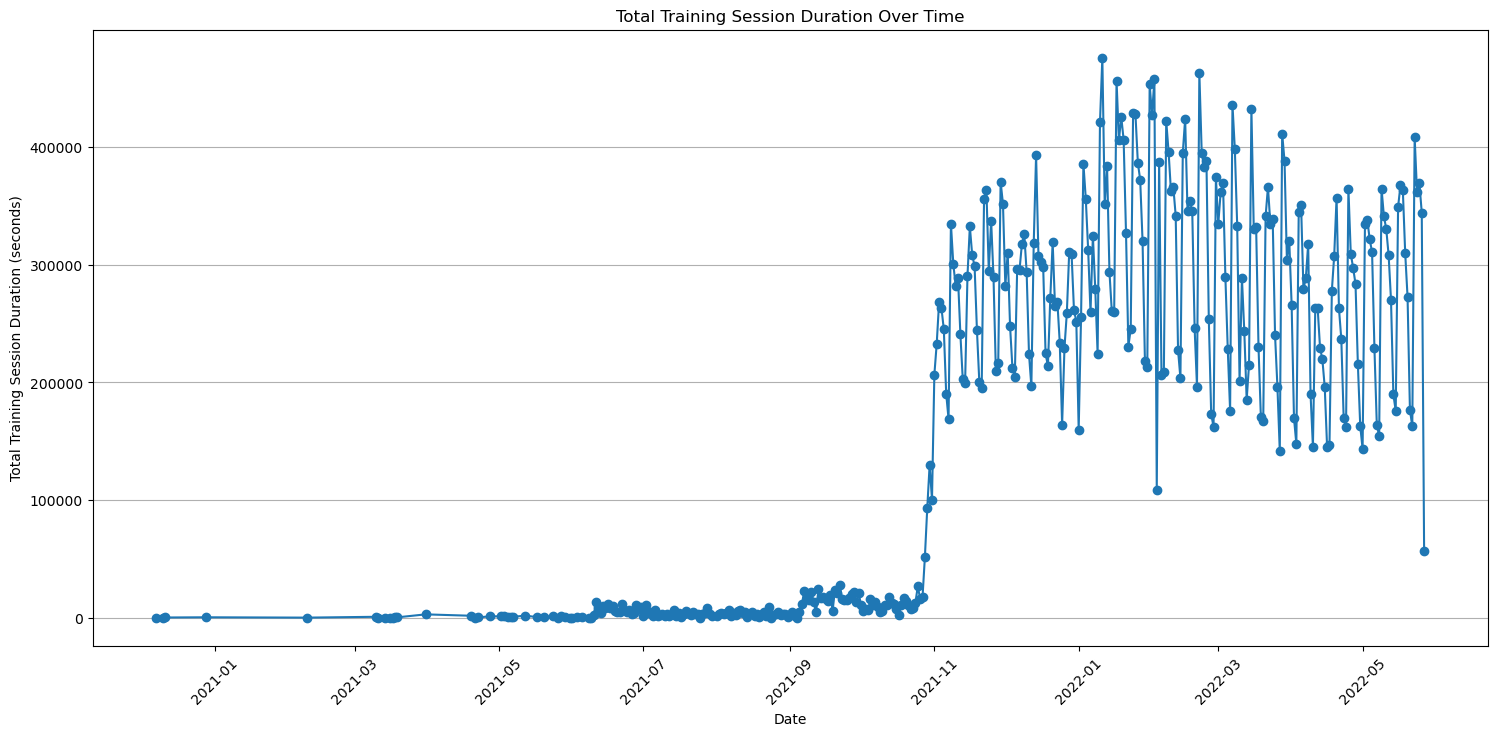

In [340]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])  
training_session_duration_over_time = df_series_recalculated.groupby('date')['sum_of_time'].sum()

plt.figure(figsize=(18, 8))
plt.plot(training_session_duration_over_time.index, training_session_duration_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Training Session Duration (seconds)')
plt.title('Total Training Session Duration Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

#### Total Rest Time per Training Session Over Time

This graph is designed to illustrate the total rest time performed in each training session over time. By plotting this data, we aim to visualize the trend of workout intensity across different sessions. It helps in identifying patterns, fluctuations, and overall progress in training effort, providing insights into how training rest time intensity changes over time. This can be useful for monitoring training progress and making informed decisions about workout adjustments.

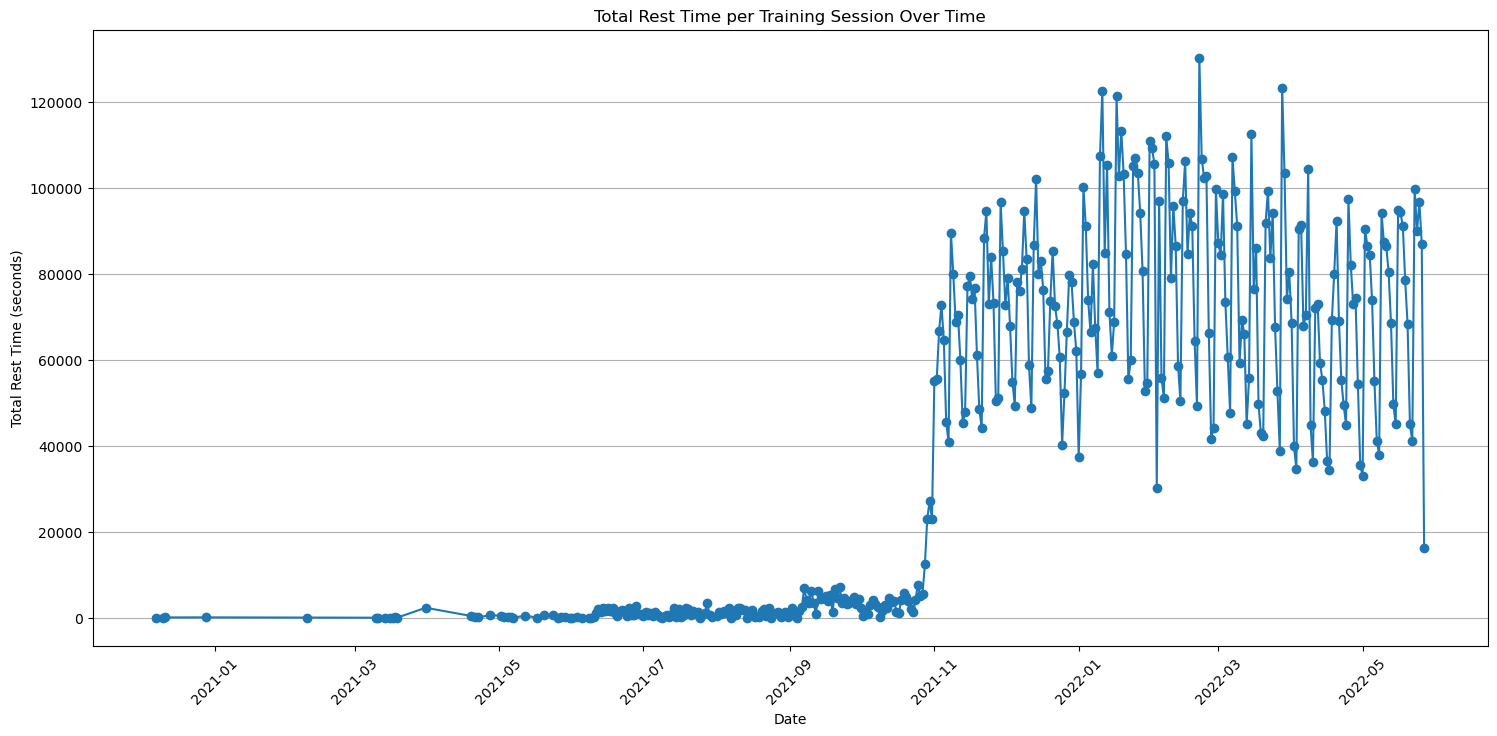

In [341]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])  
rest_time_over_time = df_series_recalculated.groupby('date')['Rest_sum_of_time_per_exercise'].sum()

plt.figure(figsize=(18, 8))
plt.plot(rest_time_over_time.index, rest_time_over_time.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Rest Time (seconds)')
plt.title('Total Rest Time per Training Session Over Time')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

---

## Box Plot Analysis - Detection of Outliers

#### Box Plot of Total Series per Training Session

This box plot visualizes the distribution of the total number of series performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the number of series per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low numbers of series in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

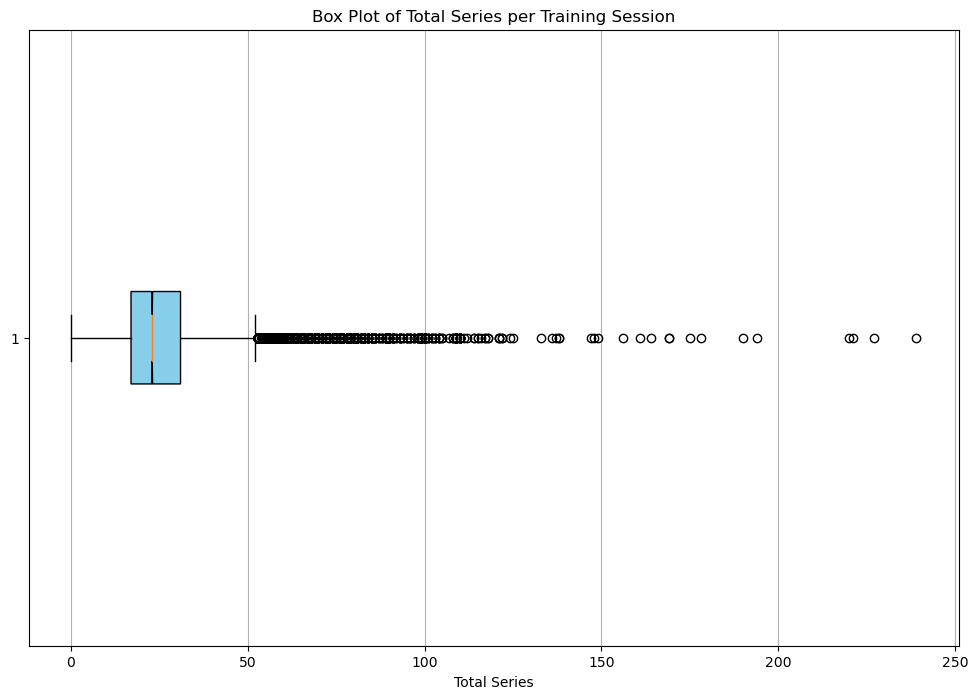

The mean number of series per training session is: 25.021237443713197 series


In [315]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])
total_count_of_series_reps = df_series_recalculated['total_count_of_series_reps']

# Create the box plot
plt.figure(figsize=(12, 8))
plt.boxplot(total_count_of_series_reps, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Total Series')
plt.title('Box Plot of Total Series per Training Session')
plt.grid(axis='x')
plt.show()

print(f'The mean number of series per training session is:', total_count_of_series_reps.mean(), 'series')

#### Box Plot of Total Repetitions per Training Session

This box plot visualizes the distribution of the total number of repetitions performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the number of repetitions per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low numbers of repetitions in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

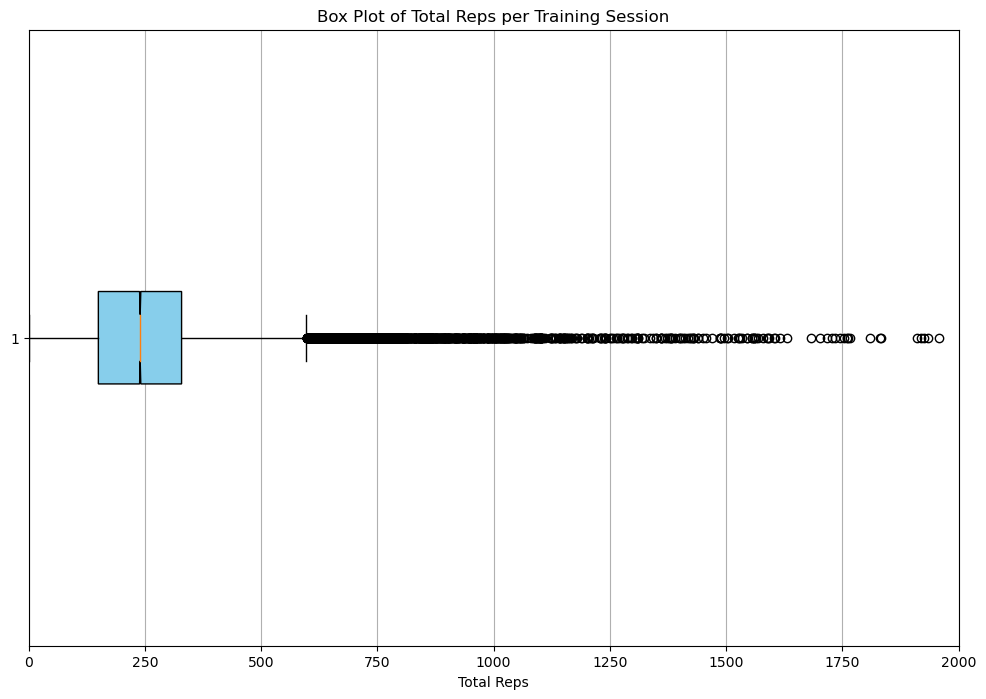

The mean number of repetitions per training session is: 55066.477874956705 reps
The maximum value for an outlier which not displayed due to the x-axis limit is located at: 2111101353.0 reps

It is important to know that there exists more outliers than the observed in the graph, but it has to be added an x-axis limit 
to have a better interpretability of the graph displayed.


In [324]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])
sum_of_reps = df_series_recalculated['sum_of_reps']

# Create the box plot
plt.figure(figsize=(12, 8))
plt.boxplot(sum_of_reps, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Total Reps')
plt.title('Box Plot of Total Reps per Training Session')
plt.xlim(0,2000)
plt.grid(axis='x')
plt.show()

print(f'The mean number of repetitions per training session is:', sum_of_reps.mean(), 'reps')
print(f'The maximum value for an outlier which not displayed due to the x-axis limit is located at:', sum_of_reps.max(), 'reps')
print('\nIt is important to know that there exists more outliers than the observed in the graph, but it has to be added an x-axis limit \nto have a better interpretability of the graph displayed.')

#### Box Plot of Total Time per Training Session

This box plot visualizes the distribution of the total time performed in each training session (this includes time doing exercise and rest time). The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the time per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low times in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

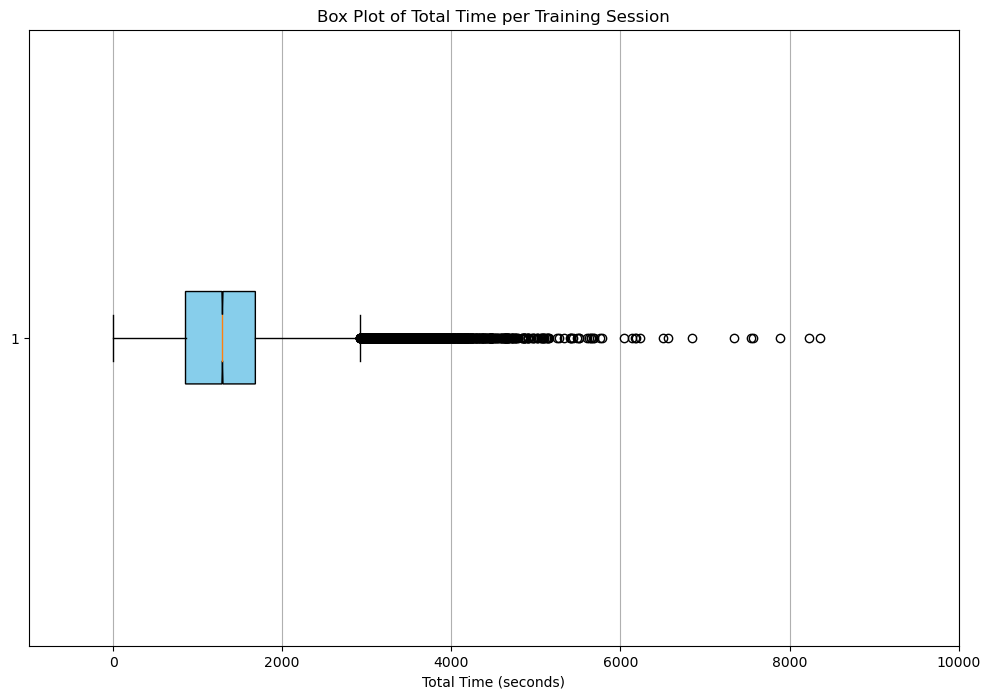

The mean time of a training session is: 1328.321895566332 seconds
The maximum value for an outlier which not displayed due to the x-axis limit is located at: 80587.0 seconds

It is important to know that there exists more outliers than the observed in the graph, but it has to be added an x-axis limit 
to have a better interpretability of the graph displayed.


In [327]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])
sum_of_time = df_series_recalculated['sum_of_time']

# Create the box plot
plt.figure(figsize=(12, 8))
plt.boxplot(sum_of_time, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Total Time (seconds)')
plt.title('Box Plot of Total Time per Training Session')
plt.xlim(-1000, 10000)
plt.grid(axis='x')
plt.show()

print(f'The mean time of a training session is:', sum_of_time.mean(), 'seconds')
print(f'The maximum value for an outlier which not displayed due to the x-axis limit is located at:', sum_of_time.max(), 'seconds')
print('\nIt is important to know that there exists more outliers than the observed in the graph, but it has to be added an x-axis limit \nto have a better interpretability of the graph displayed.')

#### Box Plot of Rest Time per Training Session

This box plot visualizes the distribution of the total rest time performed in each training session. The box plot provides a summary of the data, showing the median, quartiles, and potential outliers. The objective of this graph is to understand the spread and variability in the rest time per training session. It highlights the central tendency and dispersion of the data, as well as any extreme values that might indicate unusually high or low rest times in specific sessions. This information can be useful for analyzing consistency and identifying sessions that may require further investigation or adjustment.

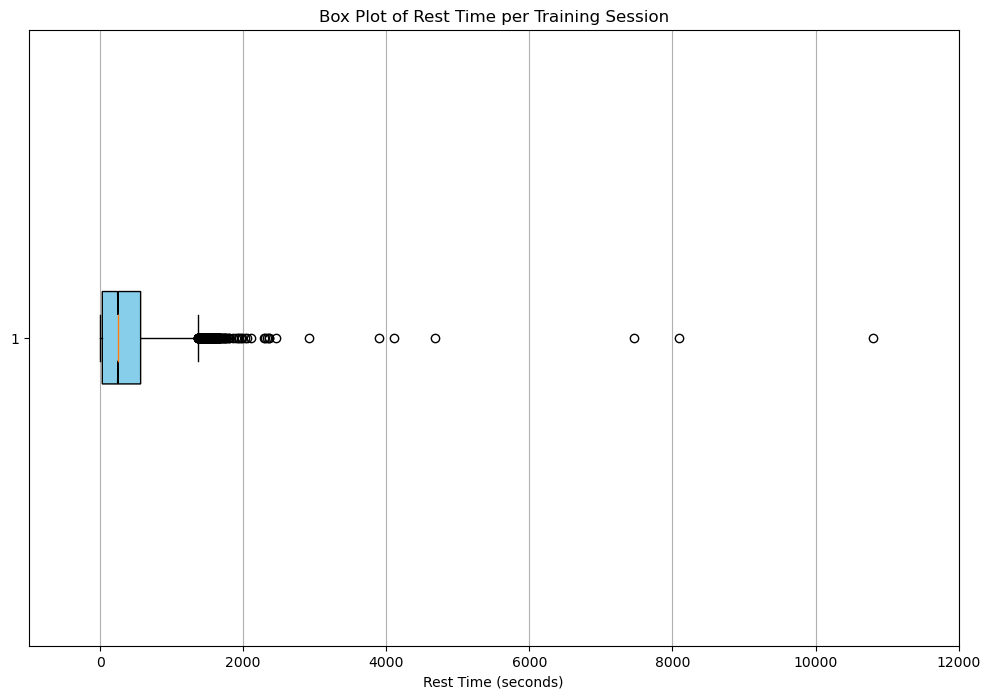

The mean rest time is: 340.04394700381016 seconds
There is another outlier not displayed due to the x-axis limit located at: 42736.0 seconds


In [313]:
df_series_recalculated['date'] = pd.to_datetime(df_series_recalculated['date'])
rest_time = df_series_recalculated['Rest_sum_of_time_per_exercise']

# Create the box plot
plt.figure(figsize=(12, 8))
plt.boxplot(rest_time, vert=False, patch_artist=True, notch=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Rest Time (seconds)')
plt.title('Box Plot of Rest Time per Training Session')
plt.xlim(-1000, 12000)
plt.grid(axis='x')
plt.show()

print(f'The mean rest time is:', rest_time.mean(), 'seconds')
print(f'There is another outlier not displayed due to the x-axis limit located at:', rest_time.max(), 'seconds')

---

## Additional Analysis

#### Training Session with Highest Number of Series

This graph aims to highlight the training sessions with the highest number of series performed. By displaying the top 10 sessions with the most series, it provides insight into the most intensive training sessions. The y-axis represents the session IDs, and the x-axis shows the number of series, allowing for easy identification of the sessions with the highest volume of work.

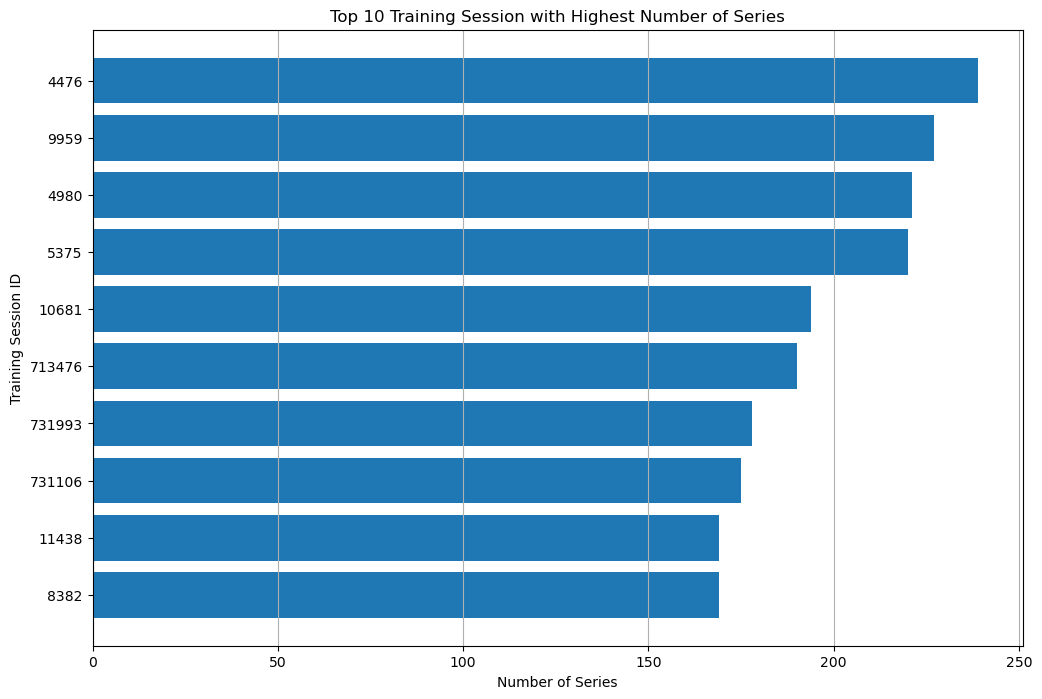

Top 10 Training Session with Highest Number of Series:
4476      239
9959      227
4980      221
5375      220
10681     194
713476    190
731993    178
731106    175
11438     169
8382      169
Name: total_count_of_series_reps, dtype: int64


In [335]:
# Filter Maximum Values
top_10_values = df_series_recalculated['total_count_of_series_reps'].nlargest(10)

# Create the graph
plt.figure(figsize=(12, 8))
plt.barh(range(10), top_10_values.values)
plt.yticks(range(10), top_10_values.index)
plt.xlabel('Number of Series')
plt.ylabel('Training Session ID')
plt.title('Top 10 Training Session with Highest Number of Series')
plt.grid(axis='x')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.show()

print('Top 10 Training Session with Highest Number of Series:')
print(top_10_values)

#### Violin Plot of Exercise Efficiency (Reps per Second) - Top 10 Exercises & Bottom 10 Exercises 

This violin plot visualizes the efficiency of different exercises, measured as the number of repetitions performed per second. It includes the top 10 exercises with the highest average efficiency. The plot aims to:

- **Show Distribution**: Highlight the spread and density of efficiency values for each exercise.
- **Identify Patterns**: Reveal any patterns or trends in how efficiently different exercises are performed.
- **Compare Exercises**: Allow easy comparison of efficiency across the top 10 exercises.
- **Highlight Variability**: Indicate the variability and consistency in exercise efficiency, with quartile lines providing additional context.

This visualization helps in understanding which exercises are performed more efficiently and how the efficiency varies for each exercise.

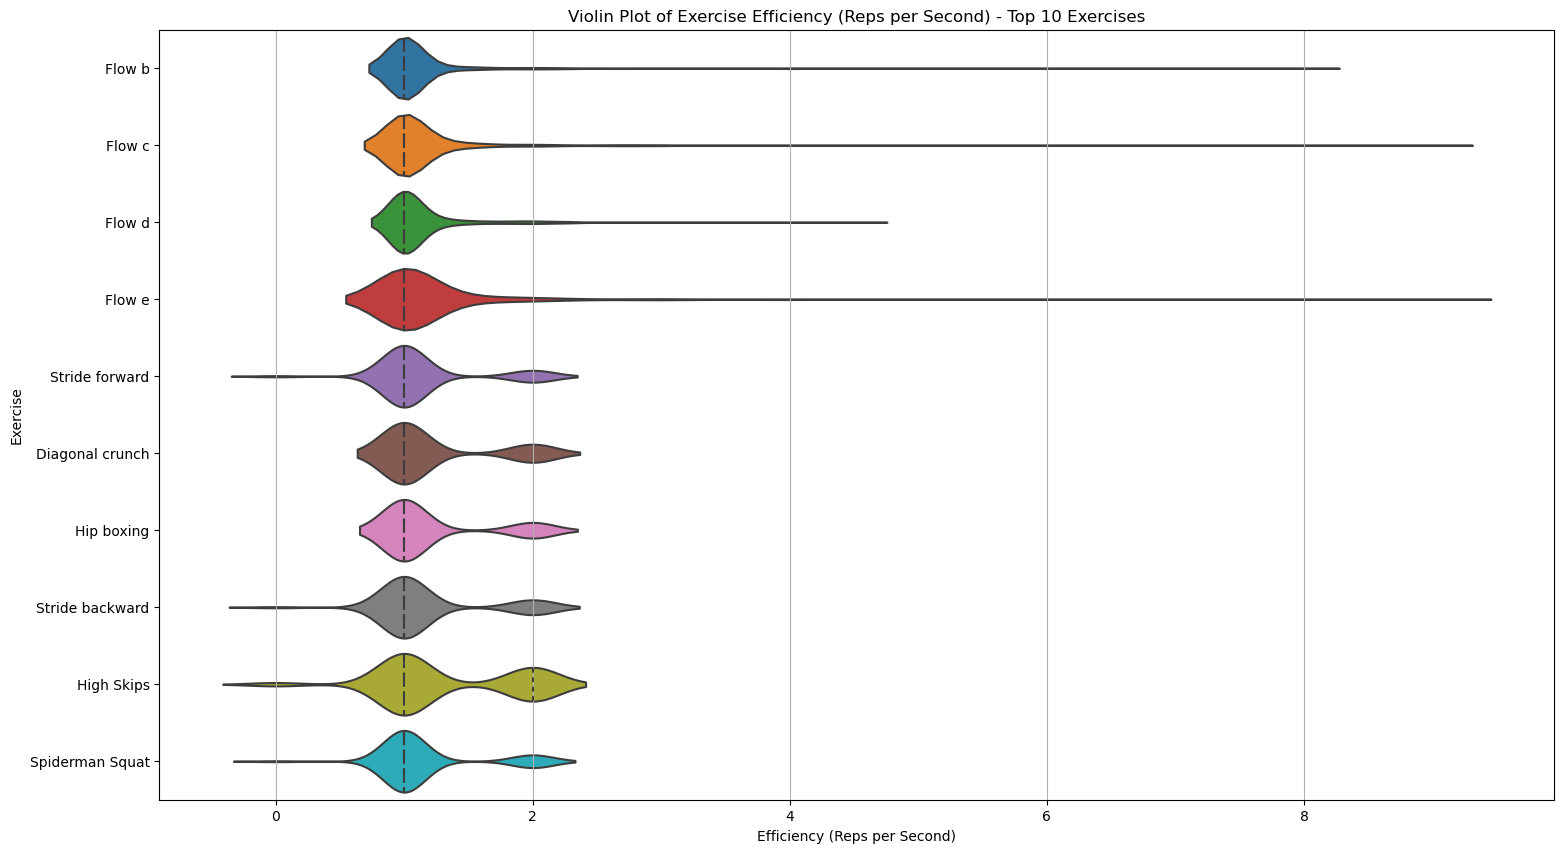

Exercise      Stride forward
Efficiency               9.0
dtype: object
Exercise      Diagonal crunch
Efficiency                0.0
dtype: object


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Exercise Efficiency (Reps per Second)
efficiency_data = []

# Loop through each exercise column ending with '_reps' and not 'sum_of_reps'
for col in df_series_recalculated.columns:
    if col.endswith('_reps') and col != 'sum_of_reps':
        exercise_name = col.replace('_reps', '')
        # Identify time column
        time_col = exercise_name + '_time'
        if time_col in df_series_recalculated.columns:
            reps = df_series_recalculated[col]
            time = df_series_recalculated[time_col]
            # Calculate efficiency
            efficiency = reps / time
            efficiency_data.append(pd.DataFrame({'Exercise': [exercise_name] * len(efficiency), 'Efficiency': efficiency}))

# Combine all efficiency data into a single DataFrame
efficiency_df = pd.concat(efficiency_data, ignore_index=True)

# Drop rows with NaN values in Efficiency
efficiency_df = efficiency_df.dropna(subset=['Efficiency'])

# Calculate the mean efficiency for each exercise
mean_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].mean()

# Get the top 10 exercises by mean efficiency
top_10_exercises = mean_efficiency.nlargest(10).index

# Filter the efficiency data to include only the top 10 exercises
filtered_efficiency_df = efficiency_df[efficiency_df['Exercise'].isin(top_10_exercises)]

# Create a violin plot for Exercise Efficiency
plt.figure(figsize=(18, 10))
sns.violinplot(data=filtered_efficiency_df, x='Efficiency', y='Exercise', scale='width', inner='quartile')
plt.xlabel('Efficiency (Reps per Second)')
plt.ylabel('Exercise')
plt.title('Violin Plot of Exercise Efficiency (Reps per Second) - Top 10 Exercises')
plt.grid(axis='x')
plt.show()

print(filtered_efficiency_df.max())
print(filtered_efficiency_df.min())

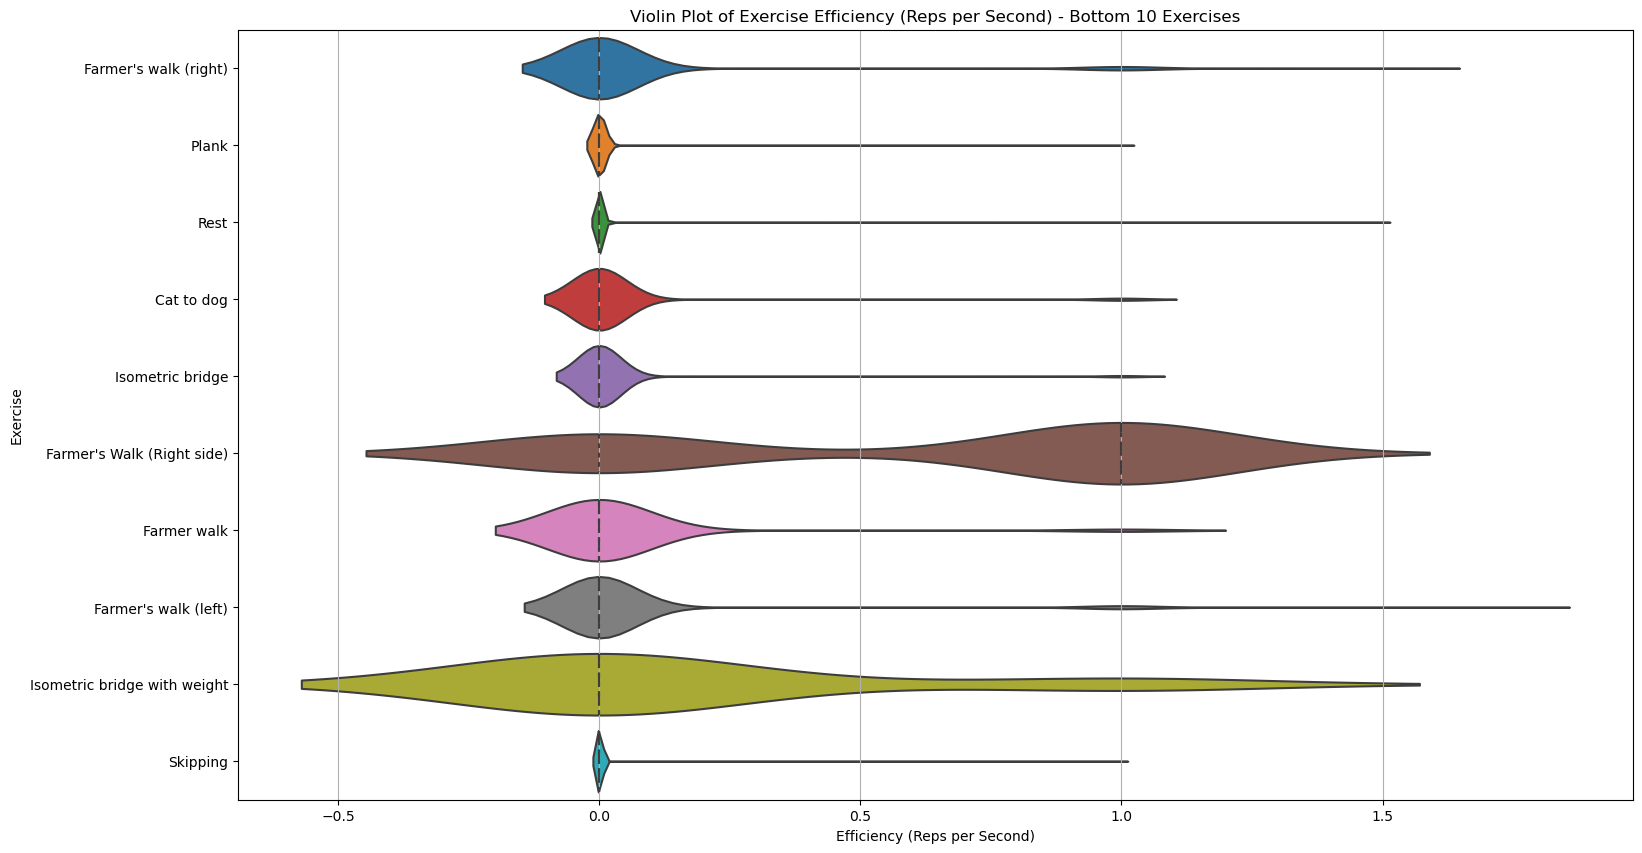

Exercise      Skipping
Efficiency    1.714286
dtype: object
Exercise      Cat to dog
Efficiency           0.0
dtype: object


In [129]:
# Calculate Exercise Efficiency (Reps per Second)
efficiency_data = []

# Loop through each exercise column ending with '_reps' and not 'sum_of_reps'
for col in df_series_recalculated.columns:
    if col.endswith('_reps') and col != 'sum_of_reps':
        exercise_name = col.replace('_reps', '')
        # Identify time column
        time_col = exercise_name + '_time'
        if time_col in df_series_recalculated.columns:
            reps = df_series_recalculated[col]
            time = df_series_recalculated[time_col]
            # Calculate efficiency
            efficiency = reps / time
            efficiency_data.append(pd.DataFrame({'Exercise': [exercise_name] * len(efficiency), 'Efficiency': efficiency}))

# Combine all efficiency data into a single DataFrame
efficiency_df = pd.concat(efficiency_data, ignore_index=True)

# Drop rows with NaN values in Efficiency
efficiency_df = efficiency_df.dropna(subset=['Efficiency'])

# Calculate the mean efficiency for each exercise
mean_efficiency = efficiency_df.groupby('Exercise')['Efficiency'].mean()

# Get the bottom 10 exercises by mean efficiency
bottom_10_exercises = mean_efficiency.nsmallest(10).index

# Filter the efficiency data to include only the bottom 10 exercises
filtered_efficiency_df = efficiency_df[efficiency_df['Exercise'].isin(bottom_10_exercises)]

# Create a violin plot for Exercise Efficiency
plt.figure(figsize=(18, 10))
sns.violinplot(data=filtered_efficiency_df, x='Efficiency', y='Exercise', scale='width', inner='quartile')
plt.xlabel('Efficiency (Reps per Second)')
plt.ylabel('Exercise')
plt.title('Violin Plot of Exercise Efficiency (Reps per Second) - Bottom 10 Exercises')
plt.grid(axis='x')
plt.show()

print(filtered_efficiency_df.max())
print(filtered_efficiency_df.min())


#### Pie Chart of Exercise Distribution by Series Count

This pie chart visualizes the distribution of the top 10 exercises based on the number of series performed. Each segment of the pie represents a specific exercise, with the size of the segment corresponding to the proportion of series counts for that exercise. The chart provides an overview of which exercises are most frequently performed in terms of series, allowing trainers and athletes to quickly identify the most common exercises in their routines. This information can be useful for balancing workouts, identifying overused exercises, or highlighting those that may need more focus. The addition of a legend and percentage labels enhances the clarity and readability of the chart.

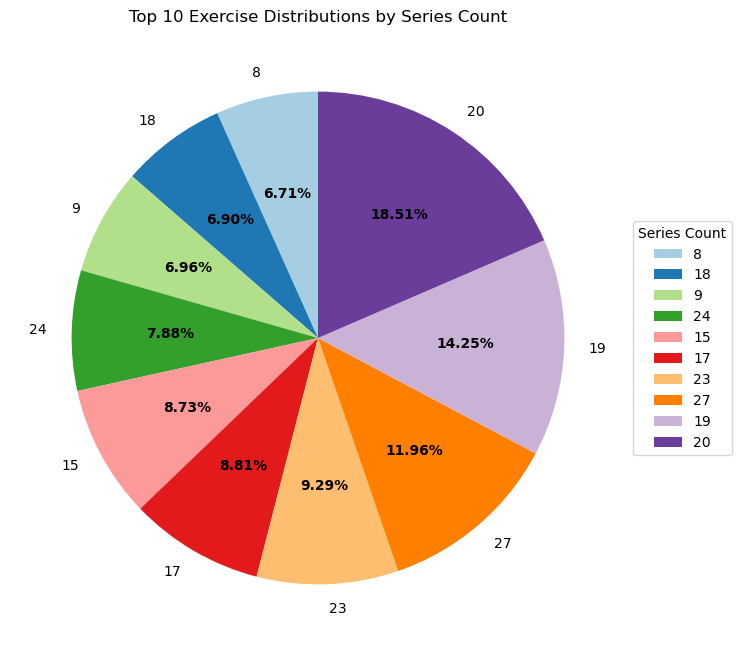

In [269]:
exercise_series_counts = df_series_recalculated['total_count_of_series_reps'].value_counts().head(10).sort_values(ascending=True)

plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(
    exercise_series_counts, 
    labels=exercise_series_counts.index, 
    autopct='%1.2f%%', 
    startangle=90,
    colors=plt.cm.Paired(np.arange(len(exercise_series_counts)))
)

plt.title('Top 10 Exercise Distributions by Series Count')
plt.legend(wedges, exercise_series_counts.index, title="Series Count", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")
plt.show()

#### Bar Chart of Average Reps per Series for Top Exercises

This graph aims to identify and display the top 10 exercises with the highest average repetitions per series. By focusing on exercises that have significant repetition counts, it highlights which exercises typically involve more effort in terms of the number of repetitions. The graph excludes columns that represent summary data or series counts, ensuring that only individual exercise repetitions are considered. This visualization is useful for trainers and athletes to understand which exercises are performed with higher repetition counts on average, helping in planning and adjusting workout routines for optimal training outcomes.

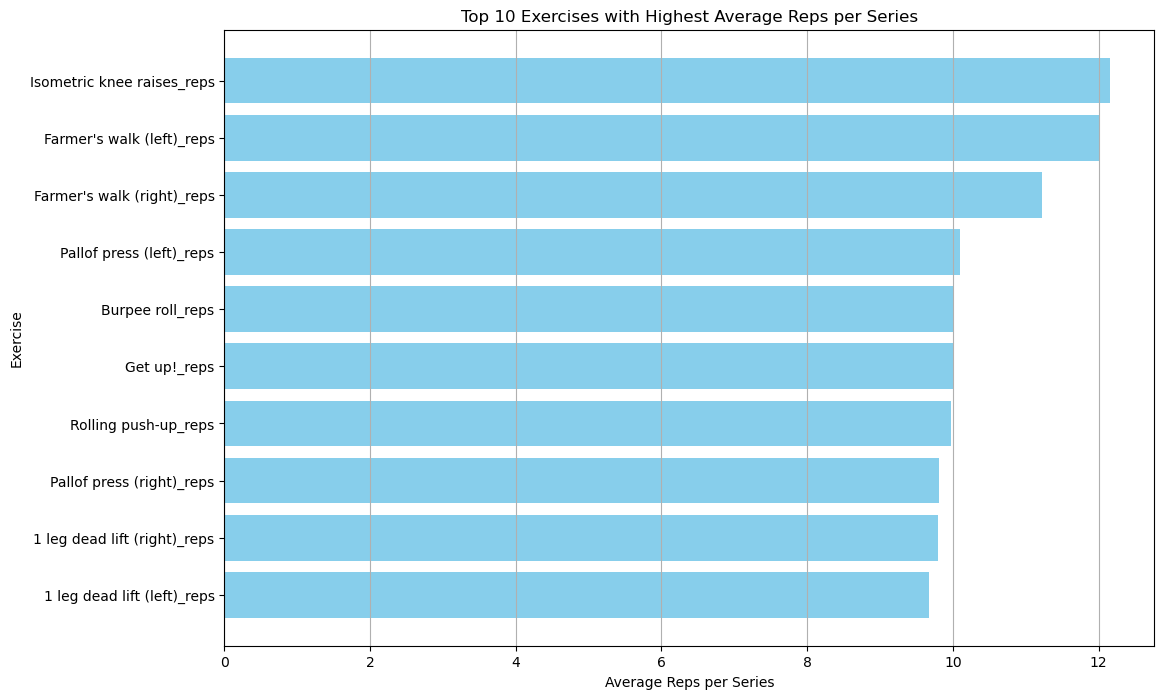

Top 10 Exercises with Highest Average Reps per Series:
                         Exercise  Average Reps per Series
306    Isometric knee raises_reps                12.156250
417     Farmer's walk (left)_reps                12.000000
48     Farmer's walk (right)_reps                11.217391
72       Pallof press (left)_reps                10.092145
228              Burpee roll_reps                10.000000
207                  Get up!_reps                10.000000
212          Rolling push-up_reps                 9.975000
73      Pallof press (right)_reps                 9.814199
129  1 leg dead lift (right)_reps                 9.799618
128   1 leg dead lift (left)_reps                 9.677419


In [336]:
import warnings
warnings.filterwarnings("ignore")

# Filter columns that ends in '_reps' and do not contain 'sum_of_reps' and 'total_count_of_series_reps'
exercise_columns = [col for col in df_series_recalculated.columns if col.endswith('_reps') and 'sum_of_reps' not in col and 'total_count_of_series_reps' not in col]

mean_reps_per_exercise = pd.DataFrame(columns=['Exercise', 'Average Reps per Series'])

# Calculate the mean values of reps per exercise and add to the DataFrame, ignoring columns which all values are 0
for col in exercise_columns:
    non_zero_values = df_series_recalculated[col][df_series_recalculated[col] != 0]
    if not non_zero_values.empty: 
        mean_reps = non_zero_values.mean()
        mean_reps_per_exercise = mean_reps_per_exercise.append({'Exercise': col, 'Average Reps per Series': mean_reps}, ignore_index=True)

mean_reps_per_exercise = mean_reps_per_exercise.sort_values(by='Average Reps per Series', ascending=False).head(10)

plt.figure(figsize=(12, 8))
plt.barh(mean_reps_per_exercise['Exercise'], mean_reps_per_exercise['Average Reps per Series'], color='skyblue')
plt.xlabel('Average Reps per Series')
plt.ylabel('Exercise')
plt.title('Top 10 Exercises with Highest Average Reps per Series')
plt.grid(axis='x')
plt.gca().invert_yaxis() 
plt.show()

print('Top 10 Exercises with Highest Average Reps per Series:')
print(mean_reps_per_exercise)

#### Training Session with Highest Rest Time

This graph aims to highlight the training sessions with the highest rest times and provide a context for these values by displaying the overall average rest time. By focusing on the top 10 sessions with the longest rest periods, the graph helps in identifying outliers or particularly significant rest intervals in the dataset. The red dashed line indicating the mean rest time serves as a reference point to compare these top values against the typical rest duration observed across all sessions. This visualization can be useful for trainers or athletes to analyze and optimize rest periods during training.

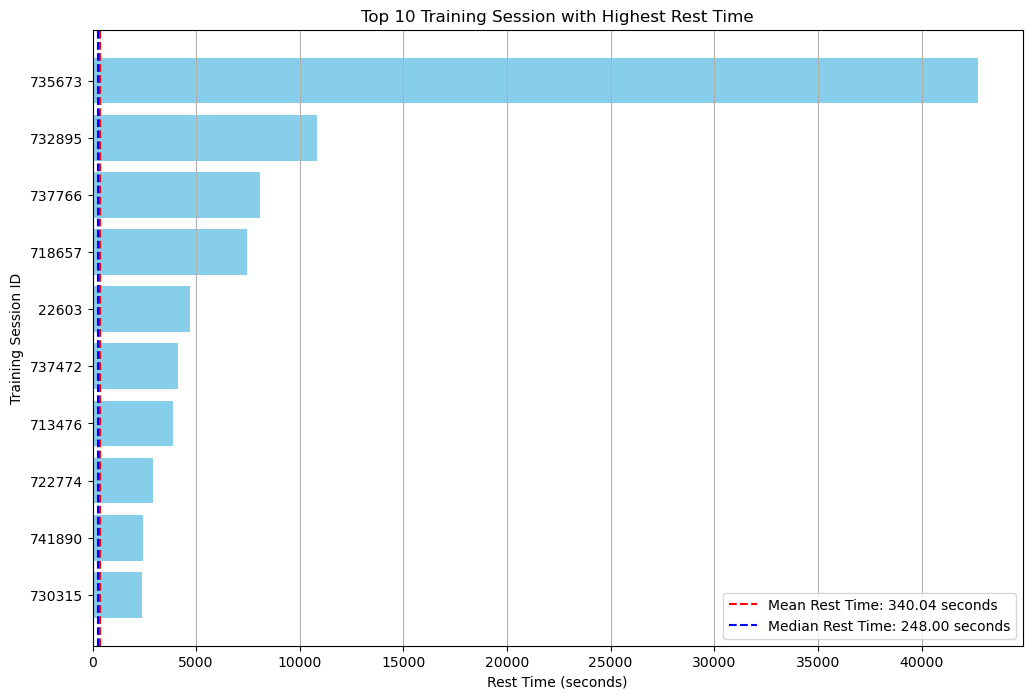

Top 10 Training Session with Highest Rest Time:
735673    42736.0
732895    10807.0
737766     8091.0
718657     7461.0
22603      4685.0
737472     4109.0
713476     3894.0
722774     2923.0
741890     2455.0
730315     2364.0
Name: Rest_sum_of_time_per_exercise, dtype: float64

Mean Rest Time: 340.04 seconds


In [328]:
# Filter Maximum Values
top_10_values = df_series_recalculated['Rest_sum_of_time_per_exercise'].nlargest(10)

# Calculate the mean rest time
mean_rest_time = df_series_recalculated['Rest_sum_of_time_per_exercise'].mean()
median_rest_time = df_series_recalculated['Rest_sum_of_time_per_exercise'].median()

plt.figure(figsize=(12, 8))
plt.barh(range(10), top_10_values.values, color='skyblue')
plt.yticks(range(10), top_10_values.index)
plt.axvline(mean_rest_time, color='r', linestyle='--', label=f'Mean Rest Time: {mean_rest_time:.2f} seconds')
plt.axvline(median_rest_time, color='b', linestyle='--', label=f'Median Rest Time: {median_rest_time:.2f} seconds')
plt.xlabel('Rest Time (seconds)')
plt.ylabel('Training Session ID')
plt.title('Top 10 Training Session with Highest Rest Time')
plt.grid(axis='x')
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest values at the top
plt.show()

print(f'Top 10 Training Session with Highest Rest Time:') 
print(top_10_values)
print(f'\nMean Rest Time: {mean_rest_time:.2f} seconds')
